In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

import re
import ftfy
import emoji
from langdetect import detect, LangDetectException

from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score,
    cross_validate
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    roc_auc_score,
    precision_score,
    recall_score
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGB_OK = True
    print('✅ XGBoost available')
except:
    XGB_OK = False
    print('⚠️ XGBoost not available')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    from umap import UMAP
    UMAP_OK = True
except:
    UMAP_OK = False

from sklearn.cluster import KMeans

sns.set(style='whitegrid', font_scale=1.0)
plt.rcParams['figure.figsize'] = (12, 6)

TRAIN_CSV = 'train_advance.csv'

print('✅ All imports loaded')


# Chunk 1 — Load & Basic Cleaning

print("[1] Loading data...")

df = pd.read_csv(TRAIN_CSV)

print(f"Raw shape: {df.shape}")
print(f"Raw columns: {df.columns.tolist()}")

df = df.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], errors="ignore")

df["following"] = pd.to_numeric(df["following"], errors="coerce")
df["n_posts"] = pd.to_numeric(df["n_posts"], errors="coerce")
df["followers"] = pd.to_numeric(df["followers"], errors="coerce")
df["numbr_likes"] = pd.to_numeric(df["numbr_likes"], errors="coerce")
df["number_comments"] = pd.to_numeric(df["number_comments"], errors="coerce")

# delete missing values
df = df.dropna(subset=["followers", "following", "numbr_likes", "number_comments", "description", "is_business_account"])

# Only keep post_type = 1 (image posts)
df = df[df["post_type"] == 1].reset_index(drop=True)
print(f"Filtered to post_type=1 only → New shape: {df.shape}")

print(f"Cleaned shape: {df.shape}")

# ---------------------------------
# Remove duplicated rows
# ---------------------------------
before = len(df)
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicated rows. New shape: {df.shape}")

# engagement rate
df["ER"] = (df["numbr_likes"] + df["number_comments"]) / (df["followers"] + 1e-6)

# ER extreme cases removal
df = df[df["ER"] <= 1]          
df = df[~((df["ER"] == 0) & (df["numbr_likes"] > 0))]   

# text cleaning
df["description"] = df["description"].fillna("").astype(str)
df["description"] = df["description"].str.lower()
df["description"] = df["description"].str.replace(r"\s+", " ", regex=True).str.strip()
df = df[df["description"].str.len() > 3]

print(f"Cleaned shape: {df.shape}")
print("Sample cleaned rows:")
print(df.head())

# Drop irrelevant columns before EDA 
drop_cols = [
    "location_id", "profile_id", "sid", "sid_profile", "post_id",
    "url", "name", "zip", "city", "region", "cd",
    "phone", "blurb", "dir_city_name", "dir_country_name",
    "aj_exact_city_match", "aj_exact_country_match",
    "lat", "lng","post_type",'profile_name',
       'firstname_lastname',
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])
print("Columns after dropping irrelevant fields:", df.columns.tolist())

# check
print("\ncheck:")
print(f"  top missing columns:")
missing = df.isnull().sum().sort_values(ascending=False).head(5)
for col, count in missing.items():
    print(f"    {col}: {count} ({count/len(df)*100:.1f}%)")

print(f"  duplicated cols: {df.duplicated().sum()}")
print(f"    Followers: {df['followers'].min():,.0f} - {df['followers'].max():,.0f}")
print(f"    Following: {df['following'].min():,.0f} - {df['following'].max():,.0f}")

print("\n✅ Chunk 1")



✅ XGBoost available


/opt/anaconda3/envs/viralpost/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All imports loaded
[1] Loading data...
Raw shape: (22924, 31)
Raw columns: ['Unnamed: 0.1', 'Unnamed: 0', 'location_id', 'profile_id', 'sid', 'sid_profile', 'post_id', 'post_type', 'description', 'numbr_likes', 'number_comments', 'profile_name', 'firstname_lastname', 'following', 'followers', 'n_posts', 'url', 'is_business_account', 'name', 'zip', 'city', 'region', 'cd', 'phone', 'aj_exact_city_match', 'aj_exact_country_match', 'blurb', 'dir_city_name', 'dir_country_name', 'lat', 'lng']
Filtered to post_type=1 only → New shape: (21697, 29)
Cleaned shape: (21697, 29)
Removed 73 duplicated rows. New shape: (21624, 29)
Cleaned shape: (21374, 30)
Sample cleaned rows:
    location_id  profile_id       sid  sid_profile      post_id  post_type  \
0  3.402839e+08   829324748  28919418       295070  Bka_6xunYma          1   
1  2.631322e+06   199074048  42114489      4342099  BxaZS4fA_nV          1   
2  6.685712e+08  3280121227  19193237      2554203  BxmEzQUFocM          1   
3  2.384617e+0

In [2]:
df.shape

(21374, 8)

In [ ]:
import re
import ftfy
import unicodedata
import emoji

def clean_text(text):
    if not isinstance(text, str):
        return ""

    text = ftfy.fix_text(text)

    text = ''.join(ch for ch in text if unicodedata.category(ch)[0] != "C")

    text = re.sub(r"http\S+|www\.\S+", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text



In [5]:
print(df.columns)

df["cleaned"] = df["description"].apply(clean_text)
if "cleaned" not in df.columns:
    raise ValueError("❌ 'cleaned' column missing! You must run cleaning first.")
else:
    print("✔ Found 'cleaned' column, safe to run add_text_features()")
    

Index(['description', 'numbr_likes', 'number_comments', 'following',
       'followers', 'n_posts', 'is_business_account', 'ER'],
      dtype='object')
✔ Found 'cleaned' column, safe to run add_text_features()


In [6]:
print(df.shape)
df.describe

(21374, 9)


<bound method NDFrame.describe of                                              description  numbr_likes  \
0         cheers to wine o‚äôclock ü•ç (üì∏: @aob1085)         4985   
1            #malcapuyaisland #bananaisland #bulogisland           57   
2      üî∏\\nschwarzkehlchen (saxicola rubicola) ‚ä¢...         1576   
3      eared grebe spotted at one of my favourite spo...           29   
4      –ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...         1487   
...                                                  ...          ...   
21619  wasn't able to get this monster weighed, but i...          195   
21620  e per chi,come noi ha paura dell'aereo...pensa...        11056   
21621  üå≥üçé some people want material things. me,...         1050   
21622  ran my first unofficial 8k race. #lululemongho...           77   
21623  the difference between a broken community and ...         1073   

       number_comments  following  followers  n_posts is_business_account  \
0           

In [ ]:
# ============================================
# Cleaning Validation Checks
# ============================================

print("\n[1.8] Validating Cleaning...")

errors = []

# ---------- 1. numeric dtype ----------
numeric_cols_expected = ["followers","following","n_posts","numbr_likes","number_comments","ER"]
for col in numeric_cols_expected:
    if col in df.columns and not np.issubdtype(df[col].dtype, np.number):
        errors.append(f"❌ Column {col} is not numeric (dtype={df[col].dtype})")

# ---------- 2. description cleaned ----------
if df["description"].isna().sum() > 0:
    errors.append("❌ description contains NaN values")

if (df["description"].str.len() == 0).sum() > 0:
    errors.append("❌ description contains empty strings")

# ---------- 3. post_type only 1 ----------
if "post_type" in df.columns:
    unique_types = df["post_type"].unique()
    if not (len(unique_types) == 1 and unique_types[0] == 1):
        errors.append(f"❌ post_type filtering failed, found: {unique_types}")

# ---------- 4. ER sanity check ----------
if (df["ER"] > 1).sum() > 0:
    errors.append("❌ ER > 1 exists (should be filtered)")

if ((df["ER"] == 0) & (df["numbr_likes"] > 0)).sum() > 0:
    errors.append("❌ Rows with ER=0 but likes>0 exist")

# ---------- 5. duplicates ----------
if df.duplicated().sum() > 0:
    errors.append("❌ Duplicated rows exist")

# ---------- 6. missing critical columns ----------
critical_cols = ["followers","numbr_likes","number_comments","description","ER"]
for col in critical_cols:
    if df[col].isna().sum() > 0:
        errors.append(f"❌ Missing values in {col}")

# ---------- 7. useless columns remain? ----------
useless_cols = [
    "region","blurb","phone","dir_city_name","dir_country_name",
    "aj_exact_city_match","aj_exact_country_match","zip","city","cd",
    "location_id","profile_id","sid","sid_profile","post_id",
    "lat","lng"
]
for col in useless_cols:
    if col in df.columns:
        errors.append(f"❌ Useless column still exists: {col}")

# ---------- Final Output ----------
if len(errors) == 0:
    print("🎉 All cleaning checks passed! Data is fully cleaned.")
else:
    print("⚠️ Cleaning issues found:")
    for e in errors:
        print("   ", e)



[1.8] Validating Cleaning...
🎉 All cleaning checks passed! Data is fully cleaned.


<Axes: >

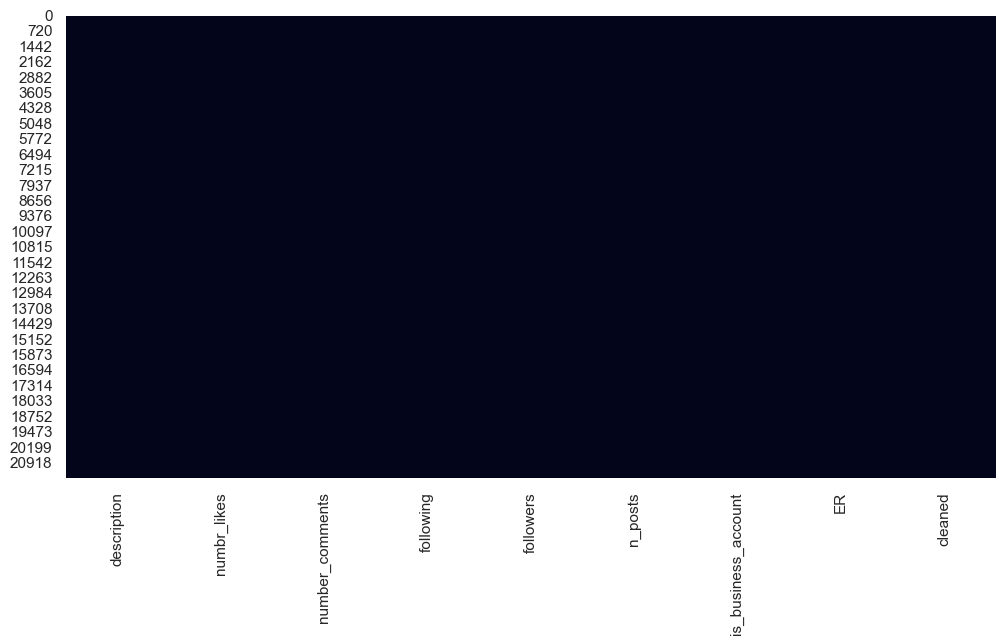

In [8]:
sns.heatmap(df.isna(), cbar=False)

In [9]:
df.shape

(21374, 9)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_theme(
    style="whitegrid",
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 15,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "axes.spines.top": False,
        "axes.spines.right": False
    }
)

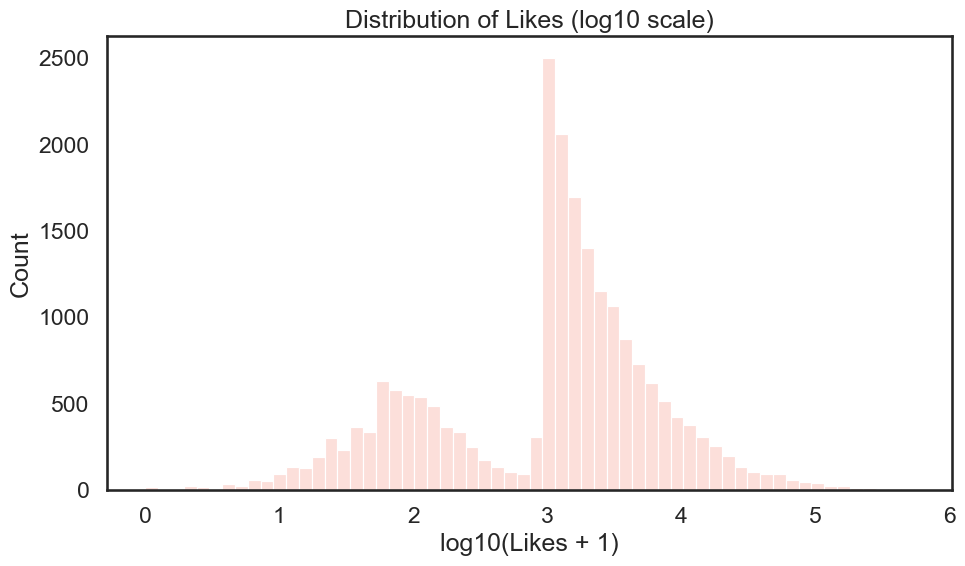

In [48]:

plt.rcParams['figure.facecolor'] = (0,0,0,0)  # Transparent figure background
plt.rcParams['savefig.transparent'] = True    # Ensure transparency when saving
plt.figure(figsize=(10,6))
sns.histplot(np.log10(df["numbr_likes"] + 1), bins=60, color="#FCD5CE")
plt.title("Distribution of Likes (log10 scale)")
plt.xlabel("log10(Likes + 1)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("1_likes_distribution.png", dpi=300)
plt.show()

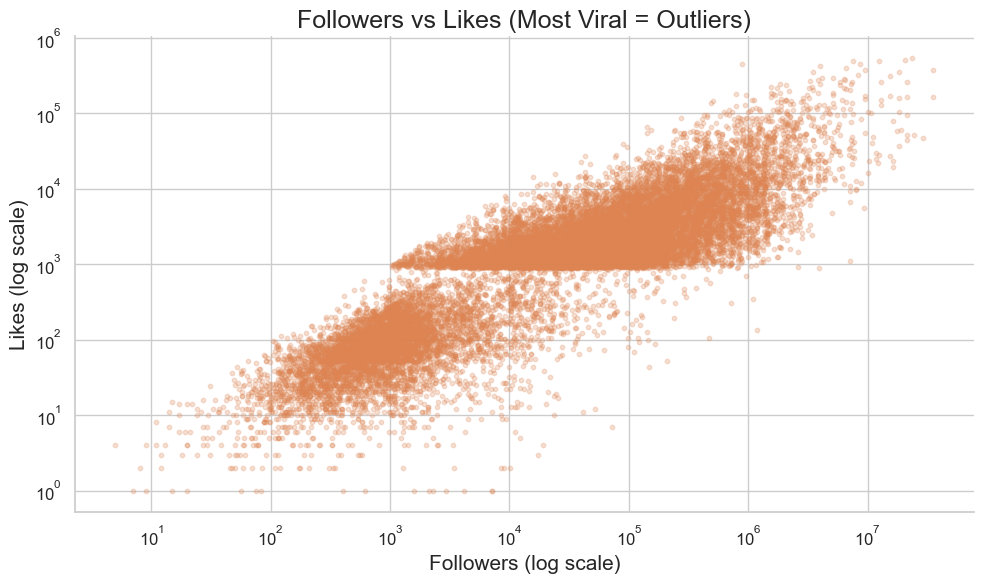

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(
    df["followers"]+1,
    df["numbr_likes"]+1,
    alpha=0.25,
    s=10,
    color="#DD8452"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Followers (log scale)")
plt.ylabel("Likes (log scale)")
plt.title("Followers vs Likes (Most Viral = Outliers)")
plt.tight_layout()
plt.savefig("2_followers_vs_likes.png", dpi=300)
plt.show()

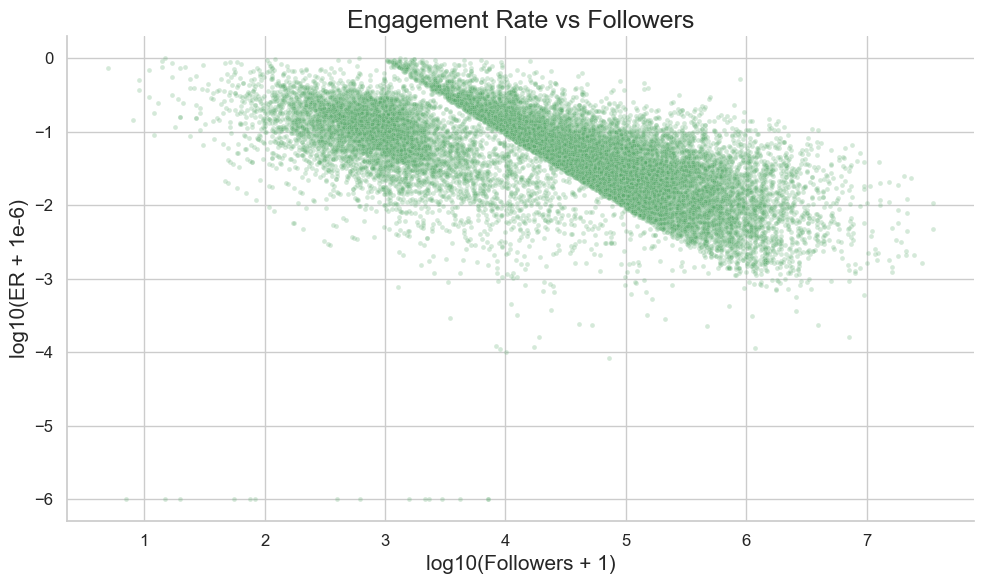

In [13]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    x=np.log10(df["followers"]+1),
    y=np.log10(df["ER"] + 1e-6),
    alpha=0.25,
    s=12,
    color="#55A868"
)

plt.xlabel("log10(Followers + 1)")
plt.ylabel("log10(ER + 1e-6)")
plt.title("Engagement Rate vs Followers")
plt.tight_layout()
plt.savefig("3_er_vs_followers.png", dpi=300)
plt.show()

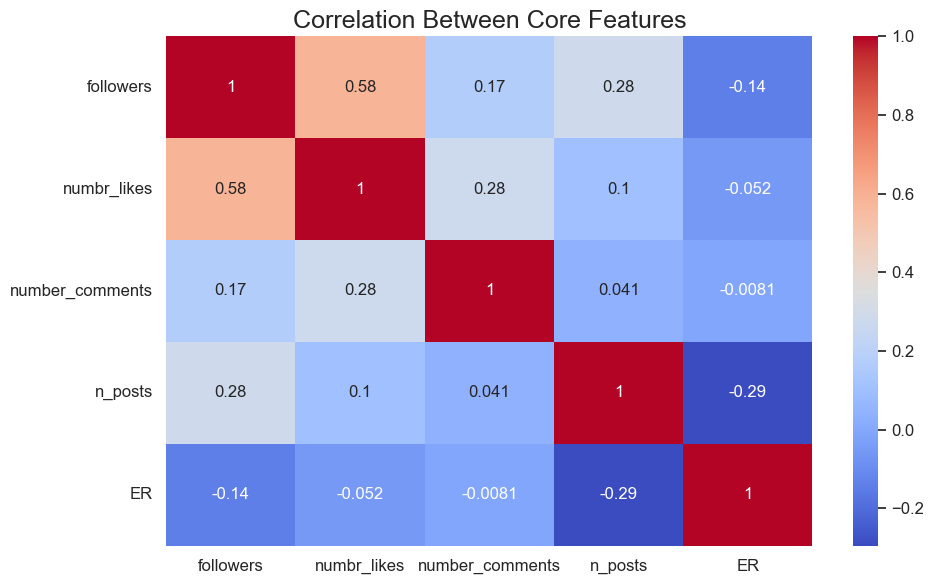

In [ ]:
core = df[["followers", "numbr_likes", "number_comments", "n_posts", "ER"]]

sns.heatmap(core.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Core Features")
plt.tight_layout()
plt.savefig("core_corr.png", dpi=300)
plt.show()

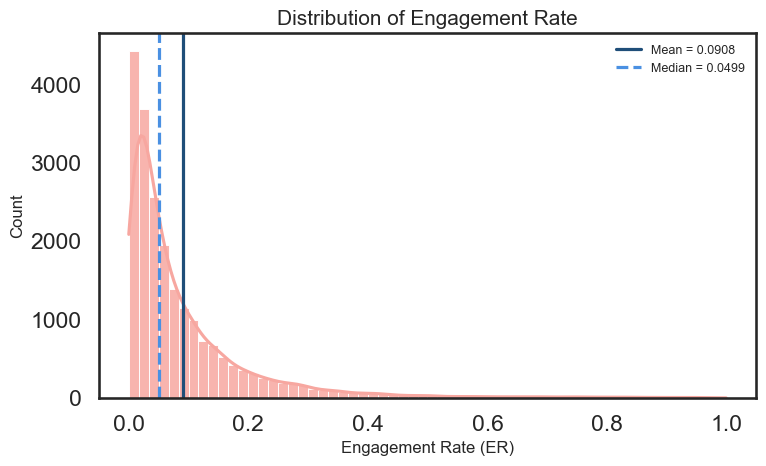

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

soft_gradient = ["#FCD5CE", "#FEC89A", "#FFB5A7", "#F7A7A0", "#F28482"]

sns.set_style("white")
plt.figure(figsize=(8,5))

# Histogram
sns.histplot(
    df['ER'],
    bins=60,
    kde=True,
    color=soft_gradient[3],
    alpha=0.85
)

# ===== Stats =====
mean_er = df['ER'].mean()
median_er = df['ER'].median()

plt.rcParams['figure.facecolor'] = (0,0,0,0)  # Transparent figure background
plt.rcParams['savefig.transparent'] = True    # Ensure transparency when saving
# ===== Vertical Lines (no viral cutoff) =====
plt.axvline(mean_er, color="#1F4E79", linestyle="-", linewidth=2.3,
            label=f"Mean = {mean_er:.4f}")

plt.axvline(median_er, color="#4A90E2", linestyle="--", linewidth=2.3,
            label=f"Median = {median_er:.4f}")

# ===== Labels =====
plt.xlabel("Engagement Rate (ER)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Engagement Rate", fontsize=15)

plt.legend(fontsize=9, frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("er_distribution_mean_median.png", dpi=300)
plt.show()

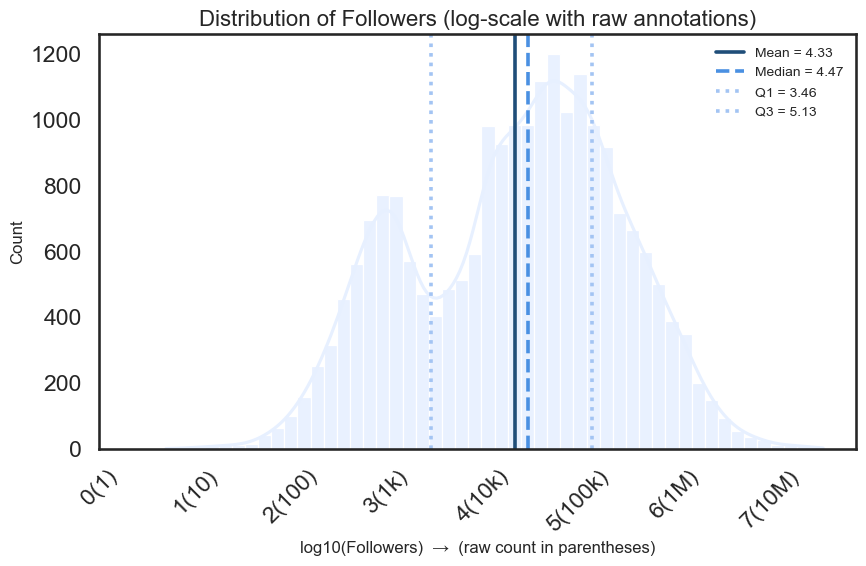

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Colors: enhanced contrast version
colors = {
    "hist":     "#E7F0FF",   # very light blue for histogram
    "mean":     "#1F4E79",   # dark strong blue
    "median":   "#4A90E2",   # vivid blue
    "quartile": "#A3C4F3"    # light blue-gray
}

# Log followers
followers_log = np.log10(df['followers'] + 1)

# Stats
mean_f = followers_log.mean()
median_f = followers_log.median()
q1_f = followers_log.quantile(0.25)
q3_f = followers_log.quantile(0.75)

sns.set_style("white")
plt.figure(figsize=(9,6))

# Histogram (lighter background)
sns.histplot(
    followers_log,
    bins=50,
    kde=True,
    color=colors["hist"],
    alpha=0.9
)

# ======== Highlighted Stat Lines ========
plt.axvline(mean_f, color=colors["mean"], linestyle="-", linewidth=2.6,
            label=f"Mean = {mean_f:.2f}")

plt.axvline(median_f, color=colors["median"], linestyle="--", linewidth=2.6,
            label=f"Median = {median_f:.2f}")

plt.axvline(q1_f, color=colors["quartile"], linestyle=":", linewidth=2.6,
            label=f"Q1 = {q1_f:.2f}")

plt.axvline(q3_f, color=colors["quartile"], linestyle=":", linewidth=2.6,
            label=f"Q3 = {q3_f:.2f}")

# ===== RAW follower annotations =====
ticks = [0, 1, 2, 3, 4, 5, 6, 7]
labels = ["0(1)", "1(10)", "2(100)", "3(1k)", "4(10k)", "5(100k)", "6(1M)", "7(10M)"]
plt.xticks(ticks, labels, rotation=45)

# Labels & title
plt.xlabel("log10(Followers)  →  (raw count in parentheses)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Followers (log-scale with raw annotations)", fontsize=16)

plt.legend(loc="upper right", frameon=False, fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.savefig("followers_distribution_with_stats.png", dpi=300)
plt.show()

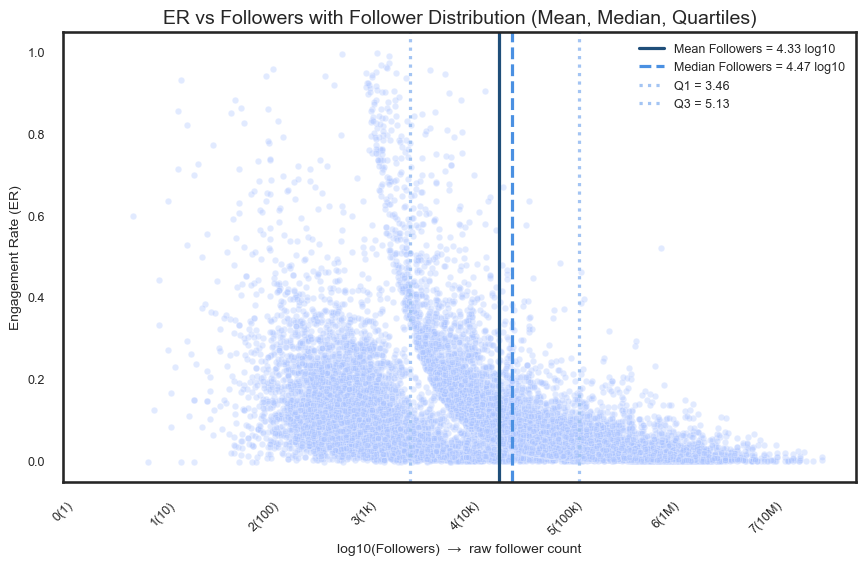

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Better contrast palette
colors = {
    "points": "#ABC4FF",       # soft lavender-blue
    "mean":   "#1F4E79",       # dark blue
    "median": "#4A90E2",       # bright medium blue
    "quartile": "#A3C4F3"      # light blue
}

# log followers
followers_log = np.log10(df["followers"] + 1)

# Compute follower stats (log-scale)
mean_f = followers_log.mean()
median_f = followers_log.median()
q1_f = followers_log.quantile(0.25)
q3_f = followers_log.quantile(0.75)

sns.set_style("white")
plt.figure(figsize=(9,6))

# Scatter plot
sns.scatterplot(
    x=followers_log,
    y=df["ER"],
    alpha=0.35,
    s=22,
    color=colors["points"]
)

# ===== Vertical follower stat lines =====
plt.axvline(mean_f, color=colors["mean"], linestyle="-", linewidth=2.3,
            label=f"Mean Followers = {mean_f:.2f} log10")

plt.axvline(median_f, color=colors["median"], linestyle="--", linewidth=2.3,
            label=f"Median Followers = {median_f:.2f} log10")

plt.axvline(q1_f, color=colors["quartile"], linestyle=":", linewidth=2.3,
            label=f"Q1 = {q1_f:.2f}")

plt.axvline(q3_f, color=colors["quartile"], linestyle=":", linewidth=2.3,
            label=f"Q3 = {q3_f:.2f}")

# Annotated x-axis: log → raw followers
ticks = [0,1,2,3,4,5,6,7]
labels = ["0(1)", "1(10)", "2(100)", "3(1k)", "4(10k)", "5(100k)", "6(1M)", "7(10M)"]
plt.xticks(ticks, labels, rotation=45, fontsize=9)
plt.yticks(fontsize=9)

# Labels & title
plt.xlabel("log10(Followers)  →  raw follower count", fontsize=10)
plt.ylabel("Engagement Rate (ER)", fontsize=10)
plt.title("ER vs Followers with Follower Distribution (Mean, Median, Quartiles)",
          fontsize=14)

plt.legend(loc="upper right", frameon=False, fontsize=9)
plt.grid(False)
plt.tight_layout()
plt.rcParams['figure.facecolor'] = (0,0,0,0)  # Transparent figure background
plt.rcParams['savefig.transparent'] = True    # Ensure transparency when saving

plt.savefig("er_vs_followers_with_follower_stats_smallfont.png", dpi=300)
plt.show()

====== DATASET SHAPE ======
Rows: 22924
Columns: 31

====== COLUMN TYPES ======
object     18
int64      11
float64     2
Name: count, dtype: int64 

====== EACH COLUMN TYPE ======
Unnamed: 0.1                int64
Unnamed: 0                  int64
location_id               float64
profile_id                  int64
sid                         int64
sid_profile                 int64
post_id                    object
post_type                   int64
description                object
numbr_likes                 int64
number_comments             int64
profile_name               object
firstname_lastname         object
following                  object
followers                   int64
n_posts                   float64
url                        object
is_business_account        object
name                       object
zip                        object
city                       object
region                     object
cd                         object
phone                      object
aj_

,Unnamed: 0.1,Unnamed: 0,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,11420,11755,3.402839e+08,829324748,28919418,295070,Bka_6xunYma,1,Cheers to wine O‚Äôclock ü•Ç (üì∏: @aob1085),4985,...,NaN,ES,+34 936 65 77 41,False,False,NaN,El Prat de Llobregat,Spain,2,41
1,24264,24967,2.631322e+06,199074048,42114489,4342099,BxaZS4fA_nV,1,#malcapuyaisland #bananaisland #bulogisland,57,...,NaN,PH,NaN,True,False,NaN,Coron,Philippines,120,11
2,16286,16768,6.685712e+08,3280121227,19193237,2554203,BxmEzQUFocM,1,üî∏\\nSchwarzkehlchen (Saxicola rubicola) ‚Ä¢...,1576,...,Saxony-Anhalt,DE,NaN,False,True,NaN,NaN,NaN,11,51
3,11139,11467,2.384617e+08,5625643374,11733129,3465973,Bjq5KFGlJvM,1,Eared Grebe spotted at one of my favourite spo...,29,...,NaN,CA,NaN,True,False,NaN,NaN,NaN,-118,52
4,27320,28111,1.005643e+09,1557071010,8540244,3541402,BweviowATmj,1,–ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...,1487,...,NaN,RU,79214201362,False,False,—Ü–µ–Ω—Ç—Ä –∏–Ω–∏—Ü–∏–∞—Ü–∏–∏ —Ç–≤–æ—Ä—á–µ—Å—Ç...,Aptekarskiy,Russia,30,59


====== MISSING SUMMARY ======
region                    22529
blurb                     16073
phone                     12956
dir_country_name          12263
dir_city_name             12263
zip                        9967
url                        8399
city                       1907
cd                         1231
description                 591
firstname_lastname          402
aj_exact_city_match         335
aj_exact_country_match      335
post_id                      34
n_posts                       5
dtype: int64 



/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/611421139.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/611421139.py:47: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(


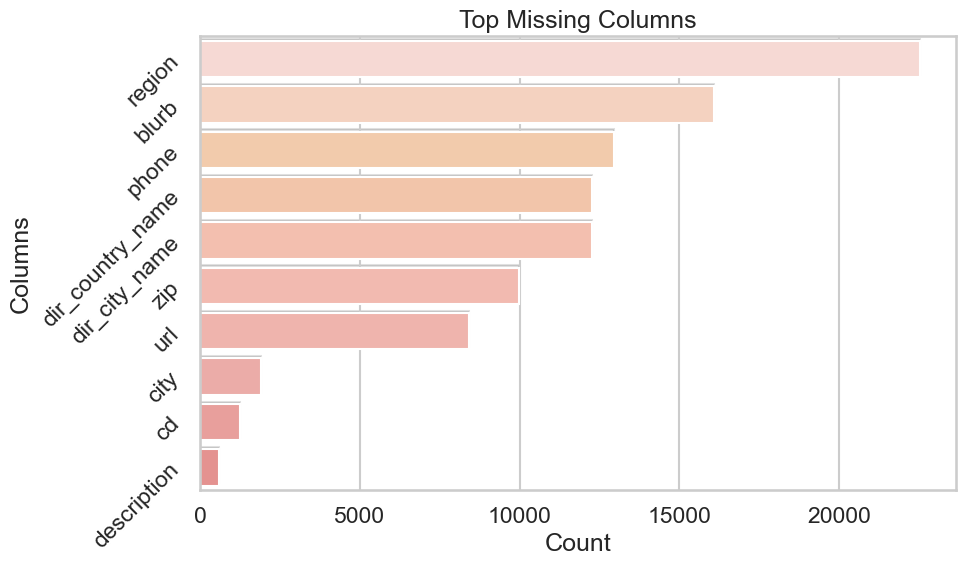

====== DUPLICATE ROWS ======
0 duplicates found

====== NUMERIC SUMMARY ======


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0.1,22924.0,1.432664e+04,8.259106e+03,0.0,7.174500e+03,14354.0,2.146325e+04,2.865400e+04
Unnamed: 0,22924.0,1.474627e+04,8.499080e+03,0.0,7.394500e+03,14779.0,2.209125e+04,2.948400e+04
location_id,22924.0,2.031771e+14,4.874348e+14,728.0,2.134705e+08,271457680.5,1.043858e+14,2.840780e+15
profile_id,22924.0,1.639743e+09,2.515905e+09,28.0,5.395078e+07,361512954.0,1.986851e+09,1.423139e+10
sid,22924.0,2.209471e+07,1.243940e+07,314127.0,1.068681e+07,19725324.5,3.447145e+07,4.333045e+07
sid_profile,22924.0,2.934882e+06,1.298506e+06,-1.0,2.187998e+06,3405434.0,3.816624e+06,4.510732e+06
post_type,22924.0,1.028180e+00,1.654906e-01,1.0,1.000000e+00,1.0,1.000000e+00,2.000000e+00
numbr_likes,22924.0,4.717406e+03,1.779134e+04,0.0,2.010000e+02,1347.0,3.121000e+03,5.441290e+05
number_comments,22924.0,7.591908e+01,7.729053e+02,0.0,4.000000e+00,18.0,5.100000e+01,9.520400e+04
followers,22924.0,2.331836e+05,9.600404e+05,0.0,2.295750e+03,28055.5,1.361772e+05,3.533971e+07


====== UNIQUE VALUES FOR CATEGORICAL FEATURES ======
post_id: 22791 unique values
description: 22126 unique values
profile_name: 19252 unique values
firstname_lastname: 18670 unique values
following: 4339 unique values
url: 11692 unique values
is_business_account: 2 unique values
name: 17018 unique values
zip: 7524 unique values
city: 5769 unique values
region: 182 unique values
cd: 183 unique values
phone: 8695 unique values
aj_exact_city_match: 2 unique values
aj_exact_country_match: 2 unique values
blurb: 6121 unique values
dir_city_name: 5318 unique values
dir_country_name: 163 unique values

Total categorical columns: 18


In [17]:
raw_df = pd.read_csv("train_advance.csv")


sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# ----------------------------
# 1. Dataset Basic Info
# ----------------------------
print("====== DATASET SHAPE ======")
print(f"Rows: {raw_df.shape[0]}")
print(f"Columns: {raw_df.shape[1]}\n")

print("====== COLUMN TYPES ======")
print(raw_df.dtypes.value_counts(), "\n")

print("====== EACH COLUMN TYPE ======")
print(raw_df.dtypes, "\n")


# ----------------------------
# 2. Preview of Raw Data
# ----------------------------
print("====== SAMPLE ROWS ======")
display(raw_df.head(5))


# ----------------------------
# 3. Missing Value Summary
# ----------------------------
print("====== MISSING SUMMARY ======")
missing = raw_df.isna().sum().sort_values(ascending=False)
print(missing.head(15), "\n")
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap


# palette = ["#EDAE49", "#D1495B", "#00798C", "#30638E", "#003D5B"]

colors = ["#FCD5CE", "#FEC89A", "#FFB5A7", "#F7A7A0", "#F28482"]
soft_cmap = LinearSegmentedColormap.from_list("soft_grad", colors, N=256)


plt.rcParams['figure.facecolor'] = (0,0,0,0)  # Transparent figure background
plt.rcParams['savefig.transparent'] = True    # Ensure transparency when saving
plt.figure()
ax = sns.barplot(
    x=missing.head(10).values,
    y=missing.head(10).index,
    palette=soft_cmap(np.linspace(0,1,10))
)

# Add soft shadow to each bar
for patch in ax.patches:
    # Create shadow rectangle *behind* the bar
    shadow = plt.Rectangle(
        (patch.get_x() + 0.05, patch.get_y() - 0.05),   # small shadow offset
        patch.get_width(),
        patch.get_height(),
        transform=ax.transData,
        color='black',
        alpha=0.12,     # soft shadow
        zorder=patch.get_zorder() - 0.5   # put shadow behind bars
    )
    ax.add_patch(shadow)

plt.title("Top Missing Columns")
plt.xlabel("Count")
plt.ylabel("Columns")
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("missing_top_columns_shadow.png", dpi=300)
plt.show()

# plt.figure()
# # plt.rcParams['figure.facecolor'] = (0,0,0,0)  # Transparent figure background
# # plt.rcParams['savefig.transparent'] = True    # Ensure transparency when saving
# sns.barplot(x=missing.head(10).values, y=missing.head(10).index, palette="rocket")
# plt.title("Top Missing Columns")
# plt.xlabel("Count")
# plt.yticks(rotation=45)
# plt.ylabel("Columns")
# plt.tight_layout()
# plt.savefig("missing_top_columns.png", dpi=300)
# plt.show()


# ----------------------------
# 4. Duplicate Check
# ----------------------------
print("====== DUPLICATE ROWS ======")
print(raw_df.duplicated().sum(), "duplicates found\n")


# ----------------------------
# 5. Numeric Summary
# ----------------------------
numeric_cols = raw_df.select_dtypes(include=[np.number]).columns
print("====== NUMERIC SUMMARY ======")
display(raw_df[numeric_cols].describe().T)


# ----------------------------
# 6. Unique Value Count for Categoricals
# ----------------------------
cat_cols = raw_df.select_dtypes(include=["object"]).columns
print("====== UNIQUE VALUES FOR CATEGORICAL FEATURES ======")
for col in cat_cols:
    print(f"{col}: {raw_df[col].nunique()} unique values")

print("\nTotal categorical columns:", len(cat_cols))

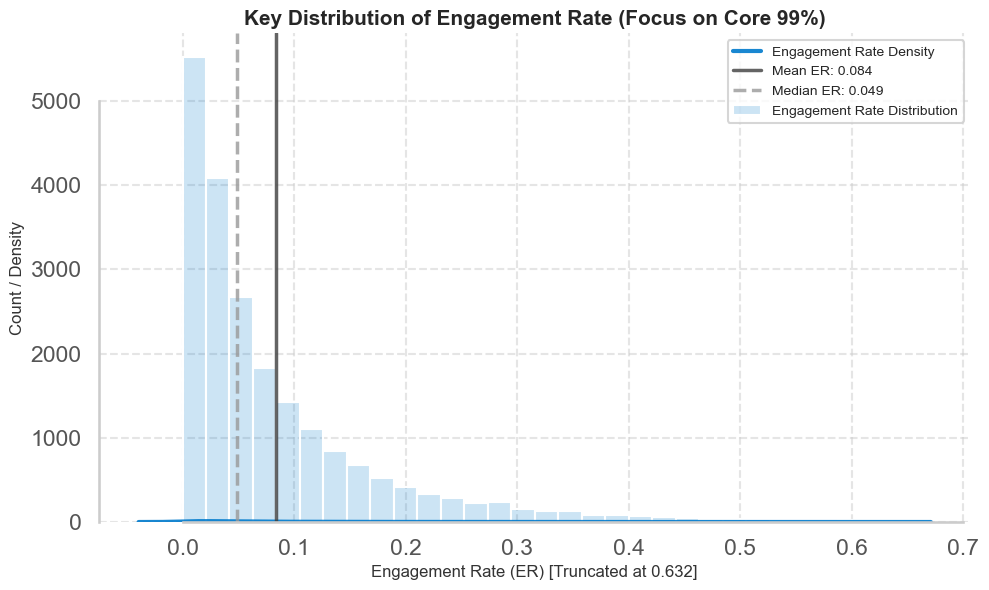

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 设定更专业的风格和更大的字体
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 10,
    'axes.titleweight': 'bold',
    'axes.labelcolor': '#333333',
    'xtick.color': '#555555',
    'ytick.color': '#555555',
    'grid.linestyle': '--',
    'grid.alpha': 0.5
})

plt.figure(figsize=(10, 6))

colors = {
    "primary": "#007ACC",       
    "secondary": "#FF6666",     
    "background_fill": "#EAF4FF", 
    "mean_line": "#3D3D3D",     
    "median_line": "#999999",   
}


er_limit = df["ER"].quantile(0.99)
df_filtered = df[df["ER"] <= er_limit]
mean_er = df_filtered["ER"].mean()
median_er = df_filtered["ER"].median()

# Histogram
sns.histplot(
    df_filtered["ER"],
    bins=30,  
    color=colors["primary"],
    alpha=0.2,
    edgecolor="white",
    label="Engagement Rate Distribution"
)

# KDE Plot
sns.kdeplot(
    df_filtered["ER"],
    color=colors["primary"],
    linewidth=3,
    alpha=0.9,
    label="Engagement Rate Density"
)


plt.axvline(mean_er, color=colors["mean_line"], linestyle="-", linewidth=2.5,
            label=f"Mean ER: {mean_er:.3f}", alpha=0.8)
plt.axvline(median_er, color=colors["median_line"], linestyle="--", linewidth=2.5,
            label=f"Median ER: {median_er:.3f}", alpha=0.8)


plt.xlabel(f"Engagement Rate (ER) [Truncated at {er_limit:.3f}]", fontsize=12)
plt.ylabel("Count / Density", fontsize=12)
plt.title("Key Distribution of Engagement Rate (Focus on Core 99%)", fontsize=15)


sns.despine(trim=True)

plt.legend(fontsize=10, loc='upper right', frameon=True, edgecolor='#cccccc')

plt.tight_layout()
plt.savefig("er_distribution_business_grade.png", dpi=300)
plt.show()

Saved: followers_simple.png


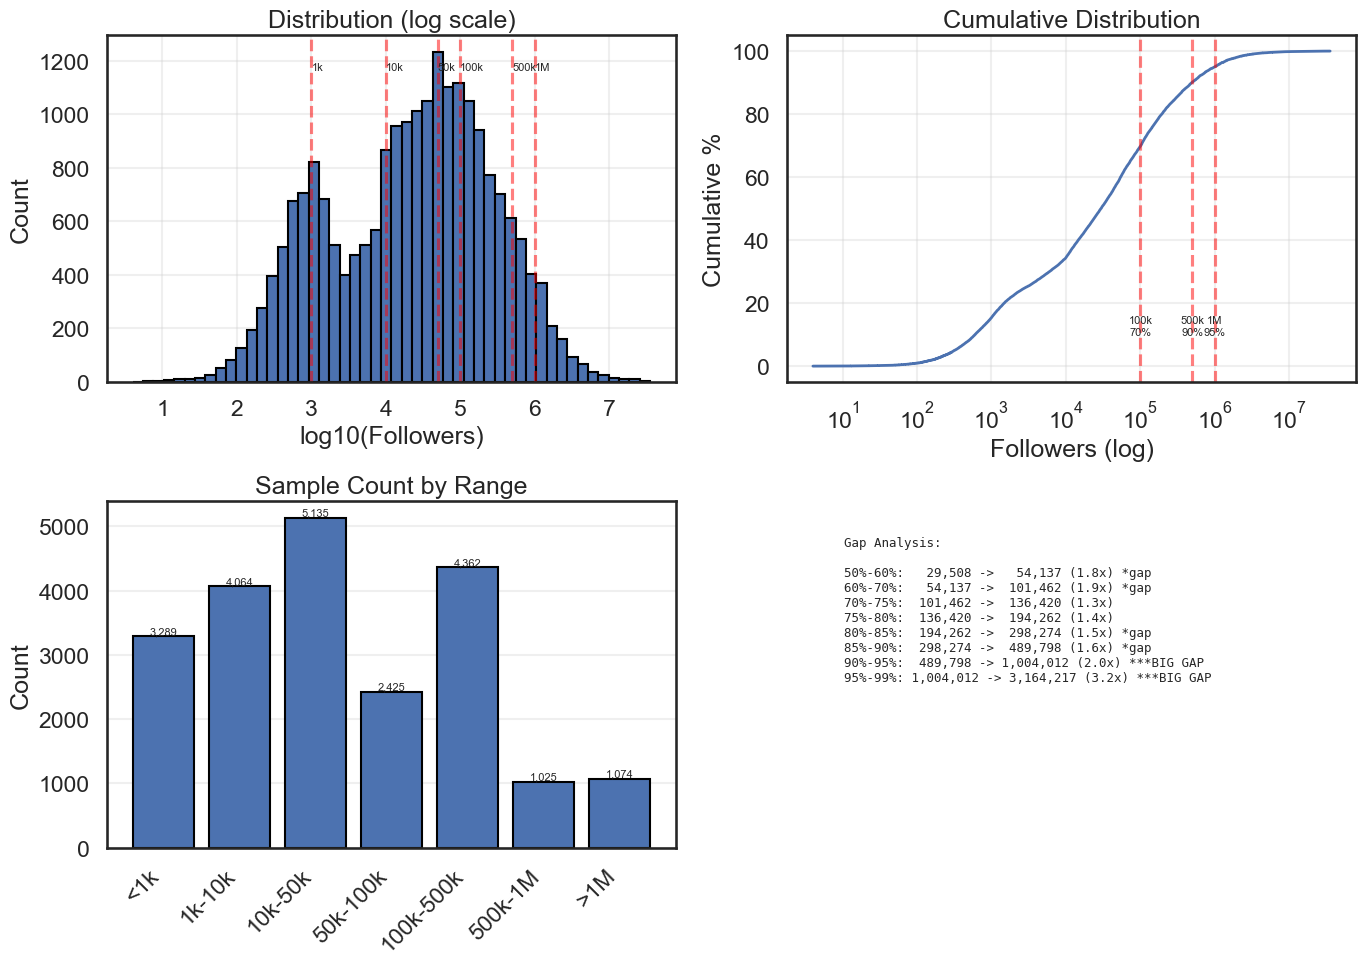

In [ ]:
# influencers check

followers = df[df['followers'] > 0]['followers']

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ============================================
# Plot 1: Histogram (log scale)
# ============================================
ax = axes[0, 0]
ax.hist(np.log10(followers), bins=50, edgecolor='black')
ax.set_xlabel('log10(Followers)')
ax.set_ylabel('Count')
ax.set_title('Distribution (log scale)')
ax.grid(True, alpha=0.3)

# Mark key thresholds
for val, label in [(1e3,'1k'), (1e4,'10k'), (5e4,'50k'), (1e5,'100k'), (5e5,'500k'), (1e6,'1M')]:
    ax.axvline(np.log10(val), color='red', linestyle='--', alpha=0.5)
    ax.text(np.log10(val), ax.get_ylim()[1]*0.9, label, fontsize=8)

# ============================================
# Plot 2: Cumulative Distribution
# ============================================
ax = axes[0, 1]
sorted_f = np.sort(followers)
cum_pct = np.arange(1, len(sorted_f)+1) / len(sorted_f) * 100
ax.plot(sorted_f, cum_pct, linewidth=2)
ax.set_xscale('log')
ax.set_xlabel('Followers (log)')
ax.set_ylabel('Cumulative %')
ax.set_title('Cumulative Distribution')
ax.grid(True, alpha=0.3)

# Mark thresholds
for val, label in [(1e5,'100k'), (5e5,'500k'), (1e6,'1M')]:
    pct = (followers < val).mean() * 100
    ax.axvline(val, color='red', linestyle='--', alpha=0.5)
    ax.text(val, 10, f'{label}\n{pct:.0f}%', fontsize=8, ha='center')

# ============================================
# Plot 3: Bar chart by ranges
# ============================================
ax = axes[1, 0]
bins = [0, 1e3, 1e4, 5e4, 1e5, 5e5, 1e6, np.inf]
labels = ['<1k', '1k-10k', '10k-50k', '50k-100k', '100k-500k', '500k-1M', '>1M']
df['bin'] = pd.cut(df['followers'], bins=bins, labels=labels)
counts = df['bin'].value_counts().sort_index()

ax.bar(range(len(counts)), counts.values, edgecolor='black')
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Sample Count by Range')
ax.grid(True, alpha=0.3, axis='y')

# Add count labels
for i, v in enumerate(counts.values):
    ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=8)

# ============================================
# Plot 4: Gap Analysis Table (text)
# ============================================
ax = axes[1, 1]
ax.axis('off')

# Calculate gaps
percentiles = [50, 60, 70, 75, 80, 85, 90, 95, 99]
text = "Gap Analysis:\n\n"
for i in range(len(percentiles)-1):
    p1, p2 = percentiles[i], percentiles[i+1]
    v1 = df['followers'].quantile(p1/100)
    v2 = df['followers'].quantile(p2/100)
    ratio = v2 / (v1 + 1)
    
    marker = ""
    if ratio >= 2.0:
        marker = " ***BIG GAP"
    elif ratio >= 1.5:
        marker = " *gap"
    
    text += f"{p1}%-{p2}%: {v1:>8,.0f} -> {v2:>8,.0f} ({ratio:.1f}x){marker}\n"

ax.text(0.1, 0.9, text, fontsize=9, family='monospace', va='top')

plt.tight_layout()
plt.savefig('followers_simple.png', dpi=150, bbox_inches='tight')
print("Saved: followers_simple.png")
plt.show()


/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/2272333189.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts.values, palette=soft, ax=ax)
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/2272333189.py:64: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=labels, y=counts.values, palette=soft, ax=ax)
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/2272333189.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


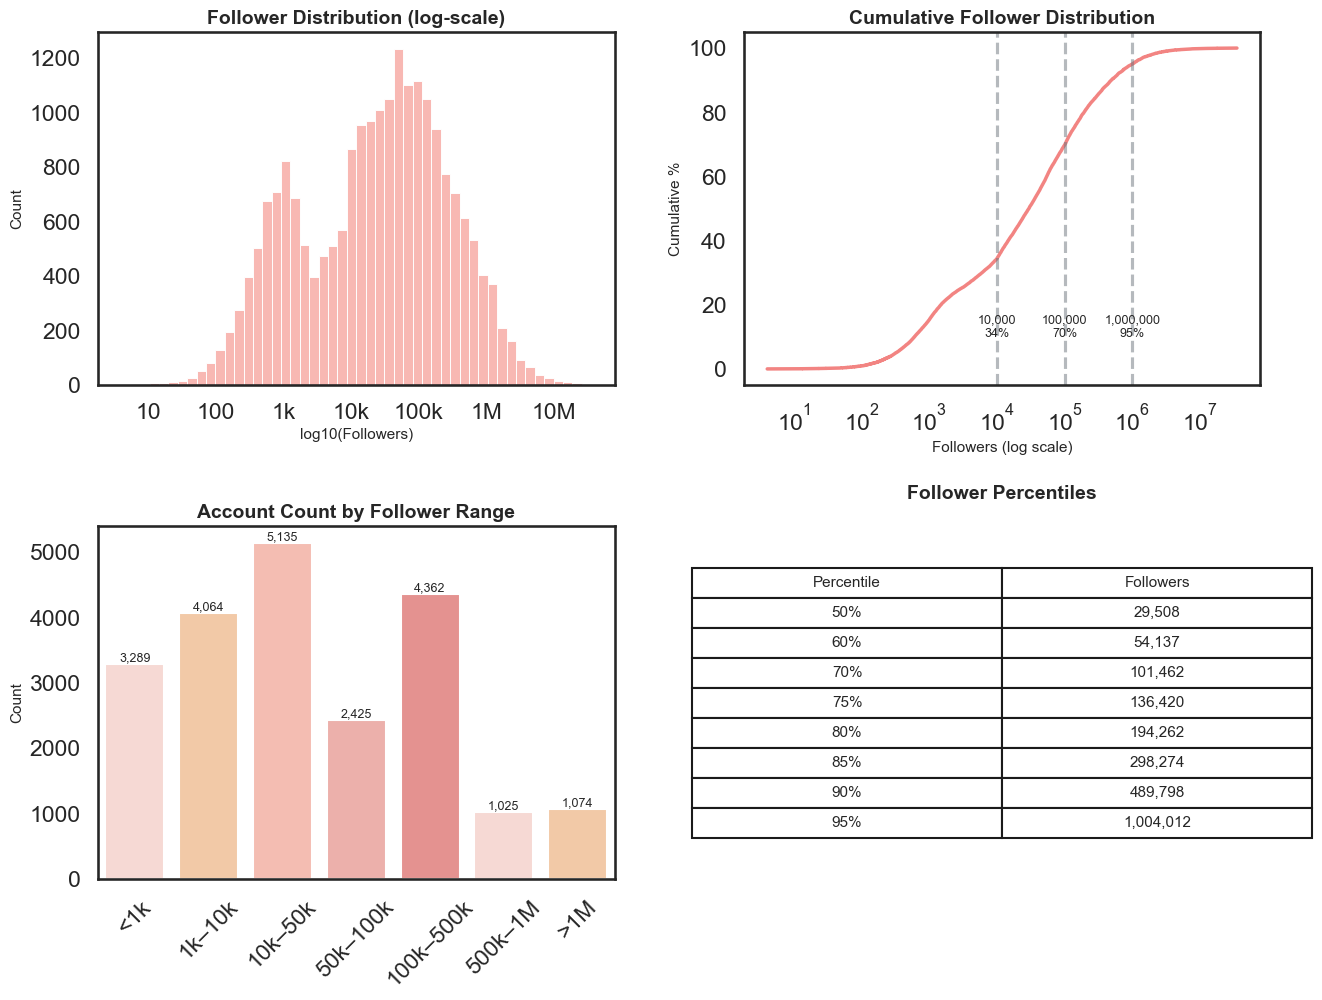

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("white")
soft = ["#FCD5CE", "#FEC89A", "#FFB5A7", "#F7A7A0", "#F28482"]

followers = df[df["followers"] > 0]["followers"]

fig, axes = plt.subplots(2, 2, figsize=(15, 11))
plt.subplots_adjust(hspace=0.4, wspace=0.25)

# ============================================================
# 1. Histogram (log-scale)
# ============================================================
ax = axes[0, 0]

followers_log = np.log10(followers)
sns.histplot(followers_log, bins=50, color=soft[3], alpha=0.8, ax=ax)

ax.set_title("Follower Distribution (log-scale)", fontsize=14)
ax.set_xlabel("log10(Followers)", fontsize=11)
ax.set_ylabel("Count", fontsize=11)

# readable ticks
ticks = [1,2,3,4,5,6,7]
labels = ["10", "100", "1k", "10k", "100k", "1M", "10M"]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

# ============================================================
# 2. Cumulative Distribution
# ============================================================
ax = axes[0, 1]

sorted_f = np.sort(followers)
cum_pct = np.arange(1, len(sorted_f)+1) / len(sorted_f) * 100

ax.plot(sorted_f, cum_pct, color=soft[4], linewidth=2.5)
ax.set_xscale("log")

ax.set_title("Cumulative Follower Distribution", fontsize=14)
ax.set_xlabel("Followers (log scale)", fontsize=11)
ax.set_ylabel("Cumulative %", fontsize=11)

# percentile markers
for val in [1e4, 1e5, 1e6]:
    ax.axvline(val, color="#6C757D", linestyle="--", alpha=0.5)
    pct = (followers < val).mean() * 100
    ax.text(val, 10, f"{int(val):,}\n{pct:.0f}%", fontsize=9, ha="center")

# ============================================================
# 3. Bar Chart by Ranges
# ============================================================
ax = axes[1, 0]

bins = [0,1e3,1e4,5e4,1e5,5e5,1e6,np.inf]
labels = ["<1k", "1k–10k", "10k–50k", "50k–100k", "100k–500k", "500k–1M", ">1M"]

df["f_bin"] = pd.cut(df["followers"], bins=bins, labels=labels)
counts = df["f_bin"].value_counts().sort_index()

sns.barplot(x=labels, y=counts.values, palette=soft, ax=ax)
ax.set_title("Account Count by Follower Range", fontsize=14)
ax.set_ylabel("Count", fontsize=11)
ax.set_xticklabels(labels, rotation=45)

for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)

# ============================================================
# 4. Gap Analysis — Pretty Table
# ============================================================
ax = axes[1, 1]
ax.axis("off")

percentiles = [50, 60, 70, 75, 80, 85, 90, 95]
rows = []
for p in percentiles:
    rows.append([f"{p}%", f"{df['followers'].quantile(p/100):,.0f}"])

table_df = pd.DataFrame(rows, columns=["Percentile", "Followers"])

the_table = ax.table(
    cellText=table_df.values,
    colLabels=table_df.columns,
    cellLoc="center",
    loc="center",
)

the_table.auto_set_font_size(False)
the_table.set_fontsize(11)
the_table.scale(1.2, 1.8)

ax.set_title("Follower Percentiles", fontsize=14, pad=20)

plt.savefig("followers_improved.png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/3778624485.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/3778624485.py:77: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/3778624485.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45)


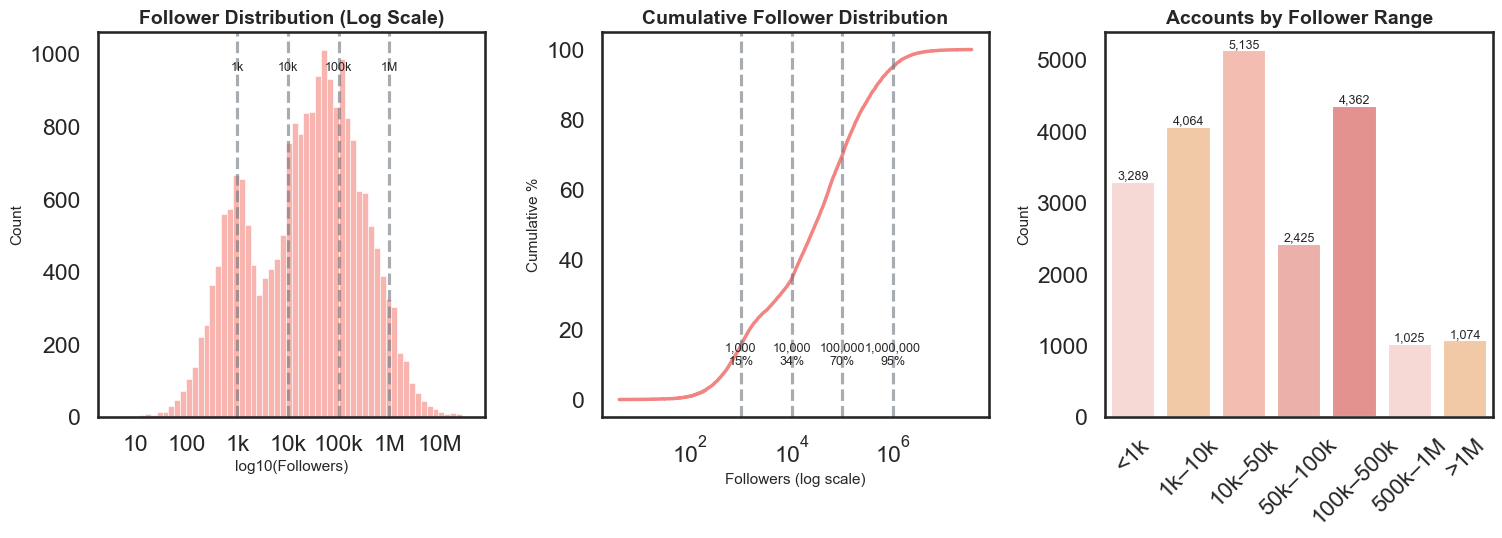

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sns.set_style("white")
soft = ["#FCD5CE", "#FEC89A", "#FFB5A7", "#F7A7A0", "#F28482"]

followers = df[df["followers"] > 0]["followers"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.3)

# ============================================================
# 1. Histogram (log-scale)
# ============================================================
ax = axes[0]

followers_log = np.log10(followers)
sns.histplot(
    followers_log,
    bins=60,
    color=soft[3],
    alpha=0.85,
    edgecolor=None,
    ax=ax
)

ax.set_title("Follower Distribution (Log Scale)", fontsize=14)
ax.set_xlabel("log10(Followers)", fontsize=11)
ax.set_ylabel("Count", fontsize=11)

# readable ticks
ticks = [1,2,3,4,5,6,7]
labels = ["10", "100", "1k", "10k", "100k", "1M", "10M"]
ax.set_xticks(ticks)
ax.set_xticklabels(labels)

# influencer cutoffs
for x,label in [(3, "1k"), (4, "10k"), (5, "100k"), (6, "1M")]:
    ax.axvline(x, color="#6C757D", linestyle="--", alpha=0.6)
    ax.text(x, ax.get_ylim()[1]*0.9, label, ha="center", fontsize=9)

# ============================================================
# 2. Cumulative Distribution
# ============================================================
ax = axes[1]

sorted_f = np.sort(followers)
cum_pct = np.arange(1, len(sorted_f)+1) / len(sorted_f) * 100

ax.plot(sorted_f, cum_pct, color=soft[4], linewidth=2.5)
ax.set_xscale("log")

ax.set_title("Cumulative Follower Distribution", fontsize=14)
ax.set_xlabel("Followers (log scale)", fontsize=11)
ax.set_ylabel("Cumulative %", fontsize=11)

# percentile overlays
for cutoff in [1e3, 1e4, 1e5, 1e6]:
    pct = (followers < cutoff).mean() * 100
    ax.axvline(cutoff, color="#6C757D", linestyle="--", alpha=0.6)
    ax.text(cutoff, 10, f"{int(cutoff):,}\n{pct:.0f}%", fontsize=9, ha="center")

# ============================================================
# 3. Bar Chart by Follower Ranges
# ============================================================
ax = axes[2]

bins = [0, 1e3, 1e4, 5e4, 1e5, 5e5, 1e6, np.inf]
labels = ["<1k", "1k–10k", "10k–50k", "50k–100k",
          "100k–500k", "500k–1M", ">1M"]

df["f_bin"] = pd.cut(df["followers"], bins=bins, labels=labels)
counts = df["f_bin"].value_counts().sort_index()

sns.barplot(
    x=labels,
    y=counts.values,
    palette=soft,
    ax=ax
)

ax.set_title("Accounts by Follower Range", fontsize=14)
ax.set_ylabel("Count", fontsize=11)
ax.set_xticklabels(labels, rotation=45)

# bar labels
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom", fontsize=9)

plt.savefig("influencer_breakpoint_dashboard.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
print("\n" + "="*60)
print("ChunkA: Influencer Classification (3 Tiers)")
print("="*60)


def get_tier(followers):
    if followers >= 1000000:
        return 'large'      # big influencer (5%)
    elif followers >= 100000:
        return 'small'      # small influencer (25%)
    else:
        return 'normal'     # normal people (70%)

df['tier'] = df['followers'].apply(get_tier)

print("\n分层标准:")
print("  普通人:      < 100k")
print("  小influencer: 100k - 1M")
print("  大influencer: > 1M")

print("\n分布:")
for tier in ['large', 'small', 'normal']:
    count = (df['tier'] == tier).sum()
    pct = count / len(df) * 100
    avg_f = df[df['tier']==tier]['followers'].mean()
    print(f"  {tier:6s}: {count:5,} ({pct:4.1f}%)  平均粉丝: {avg_f:>10,.0f}")


df['is_influencer'] = (df['tier'] != 'normal').astype(int)

# tiers (one-hot)
df['tier_normal'] = (df['tier'] == 'normal').astype(int)
df['tier_small'] = (df['tier'] == 'small').astype(int)
df['tier_large'] = (df['tier'] == 'large').astype(int)

# log followers
max_f = df['followers'].max()
df['influencer_score'] = np.log1p(df['followers']) / np.log1p(max_f)

# ============================================
# feature list
# ============================================

influencer_features = [
    'is_influencer', 
    'influencer_score',
    'tier_normal', 
    'tier_small', 
    'tier_large'
]

print(f"\n创建了 {len(influencer_features)} 个特征 (只基于 followers):")
for feat in influencer_features:
    print(f"  - {feat}")

print("\n✅ ChunkA 完成")



ChunkA: Influencer Classification (3 Tiers)

分层标准:
  普通人:      < 100k
  小influencer: 100k - 1M
  大influencer: > 1M

分布:
  large : 1,074 ( 5.0%)  平均粉丝:  2,721,655
  small : 5,387 (25.2%)  平均粉丝:    316,437
  normal: 14,913 (69.8%)  平均粉丝:     21,428

创建了 5 个特征 (只基于 followers):
  - is_influencer
  - influencer_score
  - tier_normal
  - tier_small
  - tier_large

✅ ChunkA 完成


In [ ]:
import pandas as pd
import numpy as np
%pip install tabulate
from tabulate import tabulate

# --- 1. Engagement Rate ---
df["ER"] = (df["numbr_likes"] + df["number_comments"]) / (df["followers"] + 1)
df["log_ER"] = np.log1p(df["ER"])

print("✔ ER + log_ER computed.")

# account type id

def create_combined_group_id(row):
    tier_mapping = {'normal': 0, 'small': 1, 'large': 2}
    tier_id = tier_mapping[row['tier']]
    business_id = row['is_business_account']
    return 2 * tier_id + business_id

df['account_type_id'] = df.apply(create_combined_group_id, axis=1)

TYPE_MAP = {
    0: "0: Normal User (NU)", 
    1: "1: Normal Business (NB)", 
    2: "2: Small Pure Influencer (SPI)", 
    3: "3: Small Business-Inf (SBI)",
    4: "4: Large Pure Influencer (LPI)", 
    5: "5: Large Business-Inf (LBI)"
}

print("\n✔ Mutually Exclusive Account Types (6 Tiers) Created.")
print("📊 New Account Type Distribution:")
distribution = df['account_type_id'].map(TYPE_MAP).value_counts().sort_index()
print(distribution.to_markdown()) 

def find_best_threshold(df_subset, group_val):
    percentiles_to_test = [95, 96, 96.5, 97, 97.5, 98, 98.5, 99]
    results = []
    
    group_name = TYPE_MAP.get(group_val, f"Group {group_val}")

    for p in percentiles_to_test:
        thr = df_subset["log_ER"].quantile(p / 100)
        viral_mask = df_subset["log_ER"] >= thr

        viral_mean = df_subset.loc[viral_mask, "numbr_likes"].mean()
        nonviral_mean = df_subset.loc[~viral_mask, "numbr_likes"].mean()
        ratio = viral_mean / (nonviral_mean + 1e-6) 

        results.append({
            "percentile": p,
            "threshold": thr,
            "n_viral": viral_mask.sum(),
            "viral_ratio": viral_mask.mean(),
            "likes_ratio": ratio,
            "gap_strength": np.log(ratio + 1e-6)
        })

    threshold_df = pd.DataFrame(results)
    best_idx = threshold_df["gap_strength"].idxmax()
    best_row = threshold_df.loc[best_idx]

    BEST_THRESHOLD = best_row["threshold"]

    print("\n" + "="*80)
    print(f"🏆 Best viral threshold selected for {group_name}:")
    print("="*80)
    print(f"Percentile = {best_row['percentile']}%")
    print(f"log_ER threshold = {BEST_THRESHOLD:.5f}")
    print(f"Viral ratio ≈ {best_row['viral_ratio']:.2%}")

    return BEST_THRESHOLD



GROUP_COLUMN = 'account_type_id'
groups = df[GROUP_COLUMN].unique() 

best_thresholds = {}

for group_val in sorted(groups): 
    subset_mask = df[GROUP_COLUMN] == group_val
    if subset_mask.sum() == 0:
        continue
        
    df_subset = df.loc[subset_mask].copy() 

    best_thr = find_best_threshold(df_subset, group_val)
    best_thresholds[group_val] = best_thr


df["viral_label"] = 0 

for group_val, thr in best_thresholds.items():
    condition = (df[GROUP_COLUMN] == group_val) & (df["log_ER"] >= thr)
    df.loc[condition, "viral_label"] = 1

print("\n" + "#"*80)
print("📊 Final viral_label distribution across all data:")
print("#"*80)
print(df["viral_label"].value_counts(normalize=True))

print("\n🔍 Validation: Viral ratio by group:")
validation_df = df.groupby(GROUP_COLUMN)["viral_label"].mean().reset_index()
validation_df[GROUP_COLUMN] = validation_df[GROUP_COLUMN].map(TYPE_MAP)
validation_df.rename(columns={'viral_label': 'Viral Ratio'}, inplace=True)
print(validation_df.to_markdown(index=False))

print("\n✅ Final viral_label created successfully with 6 separate thresholds.")

Note: you may need to restart the kernel to use updated packages.
✔ ER + log_ER computed.

✔ Mutually Exclusive Account Types (6 Tiers) Created.
📊 New Account Type Distribution:
| account_type_id                |   count |
|:-------------------------------|--------:|
| 0: Normal User (NU)            |    6299 |
| 1: Normal Business (NB)        |    8614 |
| 2: Small Pure Influencer (SPI) |    2307 |
| 3: Small Business-Inf (SBI)    |    3080 |
| 4: Large Pure Influencer (LPI) |     543 |
| 5: Large Business-Inf (LBI)    |     531 |

🏆 Best viral threshold selected for 0: Normal User (NU):
Percentile = 98.5%
log_ER threshold = 0.45347
Viral ratio ≈ 1.51%

🏆 Best viral threshold selected for 1: Normal Business (NB):
Percentile = 96.5%
log_ER threshold = 0.36314
Viral ratio ≈ 3.51%

🏆 Best viral threshold selected for 2: Small Pure Influencer (SPI):
Percentile = 99.0%
log_ER threshold = 0.15782
Viral ratio ≈ 1.04%

🏆 Best viral threshold selected for 3: Small Business-Inf (SBI):
Percentil

In [ ]:
print(df['viral_label'].value_counts())

print("\n" + "#"*80)
print("📊 Final viral_label distribution across all data:")
print("#"*80)

total_counts = df["viral_label"].value_counts(dropna=False)
total_proportions = df["viral_label"].value_counts(normalize=True, dropna=False)

distribution_df = pd.DataFrame({
    'Count': total_counts,
    'Proportion': total_proportions.apply(lambda x: f"{x:.2%}")
})
distribution_df.index = ['Non-Viral (0)', 'Viral (1)']

print(distribution_df.to_markdown())

TYPE_MAP = {
    0: "0: Normal User (NU)", 
    1: "1: Normal Business (NB)", 
    2: "2: Small Pure Influencer (SPI)", 
    3: "3: Small Business-Inf (SBI)",
    4: "4: Large Pure Influencer (LPI)", 
    5: "5: Large Business-Inf (LBI)"
}

print("\n🔍 Validation: Viral ratio by 6 Account Tiers (should be similar for each tier):")
validation_df = df.groupby('account_type_id')["viral_label"].agg(['count', 'mean']).reset_index()
validation_df['account_type_id'] = validation_df['account_type_id'].map(TYPE_MAP)
validation_df.rename(columns={'account_type_id': 'Account Type', 
                              'count': 'Total Posts in Group', 
                              'mean': 'Viral Ratio in Group'}, inplace=True)
validation_df['Viral Ratio in Group'] = validation_df['Viral Ratio in Group'].apply(lambda x: f"{x:.2%}")

print(validation_df.to_markdown(index=False))

viral_label
0    20899
1      475
Name: count, dtype: int64

################################################################################
📊 Final viral_label distribution across all data:
################################################################################
|               |   Count | Proportion   |
|:--------------|--------:|:-------------|
| Non-Viral (0) |   20899 | 97.78%       |
| Viral (1)     |     475 | 2.22%        |

🔍 Validation: Viral ratio by 6 Account Tiers (should be similar for each tier):
| Account Type                   |   Total Posts in Group | Viral Ratio in Group   |
|:-------------------------------|-----------------------:|:-----------------------|
| 0: Normal User (NU)            |                   6299 | 1.51%                  |
| 1: Normal Business (NB)        |                   8614 | 3.51%                  |
| 2: Small Pure Influencer (SPI) |                   2307 | 1.04%                  |
| 3: Small Business-Inf (SBI)    |               

In [61]:
def extract_emojis(text):
    return "".join(ch for ch in text if ch in emoji.EMOJI_DATA)

def count_emojis(text):
    return sum(1 for ch in text if ch in emoji.EMOJI_DATA)

def extract_hashtags(text):
    return re.findall(r"#\w+", text)

def count_hashtags(text):
    return len(extract_hashtags(text))

def add_text_features(df):
    
    print("\n🔧 Extracting text features...")

    df["emoji_str"] = df["cleaned"].apply(extract_emojis)
    df["emoji_count"] = df["cleaned"].apply(count_emojis)
    df["hashtag_count"] = df["cleaned"].apply(count_hashtags)
    df["text_length"] = df["cleaned"].str.len()
    df["word_count"] = df["cleaned"].apply(lambda x: len(x.split()))
    df["punct_ratio"] = df["cleaned"].apply(lambda x: sum(1 for c in x if c in "!?.,") / (len(x) + 1e-6))
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sent = df["cleaned"].apply(lambda x: analyzer.polarity_scores(x))
    df["sent_pos"] = sent.apply(lambda x: x["pos"])
    df["sent_neu"] = sent.apply(lambda x: x["neu"])
    df["sent_neg"] = sent.apply(lambda x: x["neg"])
    df["sent_compound"] = sent.apply(lambda x: x["compound"])

    # SANITY CHECK
    print(df[[
        "cleaned","emoji_count","hashtag_count",
        "text_length","word_count","sent_compound"
    ]].sample(5))

    return df

In [62]:
df = add_text_features(df)


🔧 Extracting text features...
                                                 cleaned  emoji_count  \
16418  yeeeehaw!! 'ù§ô∏è we hebben prachtige dingen g...            1   
11514  makeover for @thesavage_clown by teamtbcc.. @t...            0   
8543   –ö—é–¥–∞ –±—ã —å—é–ω—é—ç—å—å—è, —á—ç–æ–±—ã –ø–...            0   
7046   #kirnevfamily #–∫–∏—ä–ω–µ–≤ #–∑–∞–ø–∏—å—å #—å–...            0   
3264   salah satu perbedaan orang yang psikopat dan b...            0   

       hashtag_count  text_length  word_count  sent_compound  
16418              0          141          21        -0.4184  
11514              5          285          21         0.0000  
8543               0         3854         302         0.0000  
7046               1           65           4         0.0000  
3264               0          221          36         0.0000  


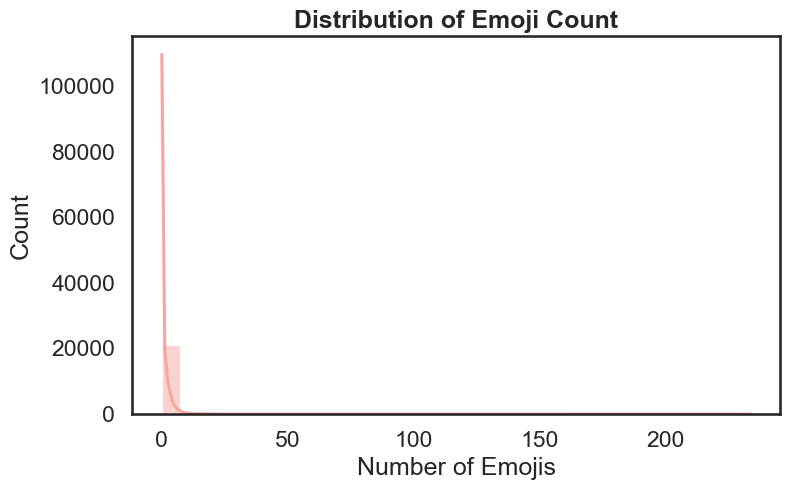

In [63]:
sns.set_style("white")
plt.figure(figsize=(8,5))
sns.histplot(df["emoji_count"], bins=30, kde=True, color="#F7A7A0")
plt.title("Distribution of Emoji Count")
plt.xlabel("Number of Emojis")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

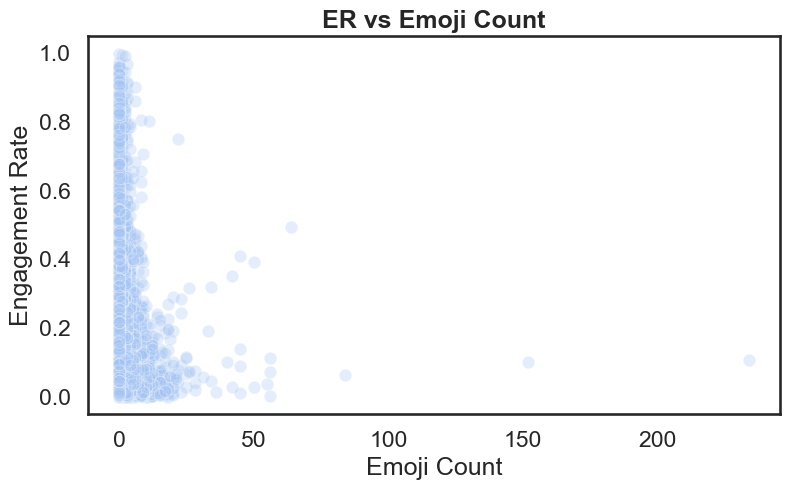

In [64]:
sns.set_style("white")
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="emoji_count", y="ER", alpha=0.3, color="#A3C4F3")
plt.title("ER vs Emoji Count")
plt.xlabel("Emoji Count")
plt.ylabel("Engagement Rate")
plt.tight_layout()
plt.show()

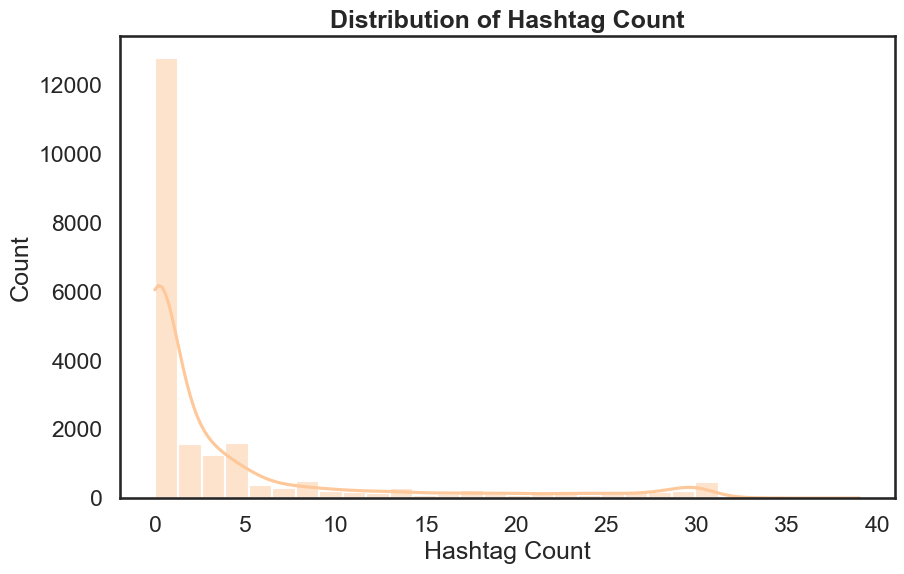

In [65]:
sns.histplot(df["hashtag_count"], bins=30, kde=True, color="#FEC89A")
plt.title("Distribution of Hashtag Count")
plt.xlabel("Hashtag Count")
plt.ylabel("Count")
plt.show()

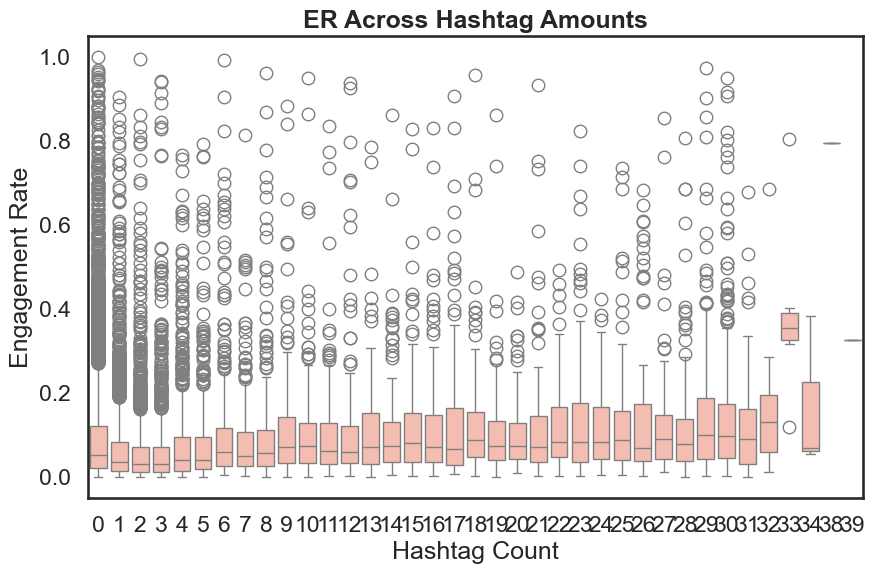

In [66]:
sns.boxplot(data=df, x="hashtag_count", y="ER", color="#FFB5A7")
plt.title("ER Across Hashtag Amounts")
plt.xlabel("Hashtag Count")
plt.ylabel("Engagement Rate")
plt.show()


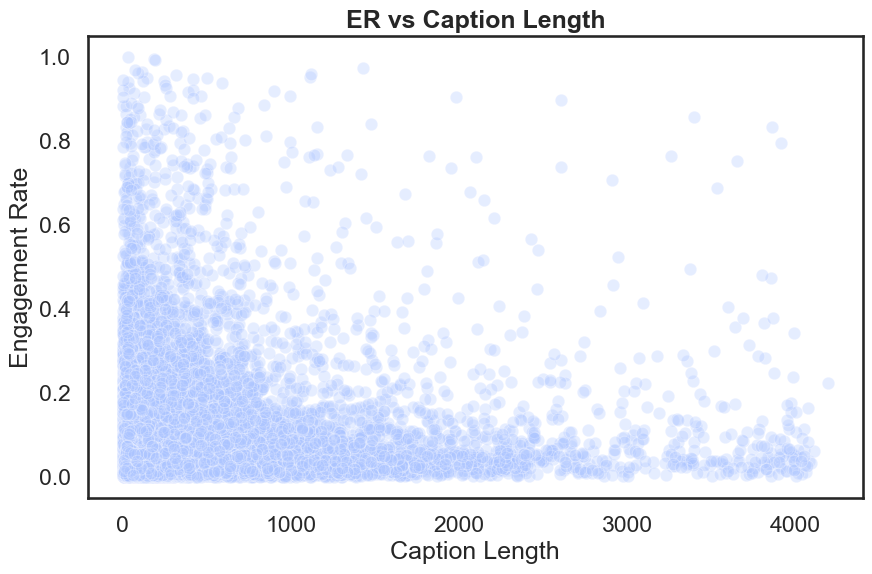

In [67]:
sns.scatterplot(data=df, x="text_length", y="ER", alpha=0.3, color="#ABC4FF")
plt.title("ER vs Caption Length")
plt.xlabel("Caption Length")
plt.ylabel("Engagement Rate")
plt.show()

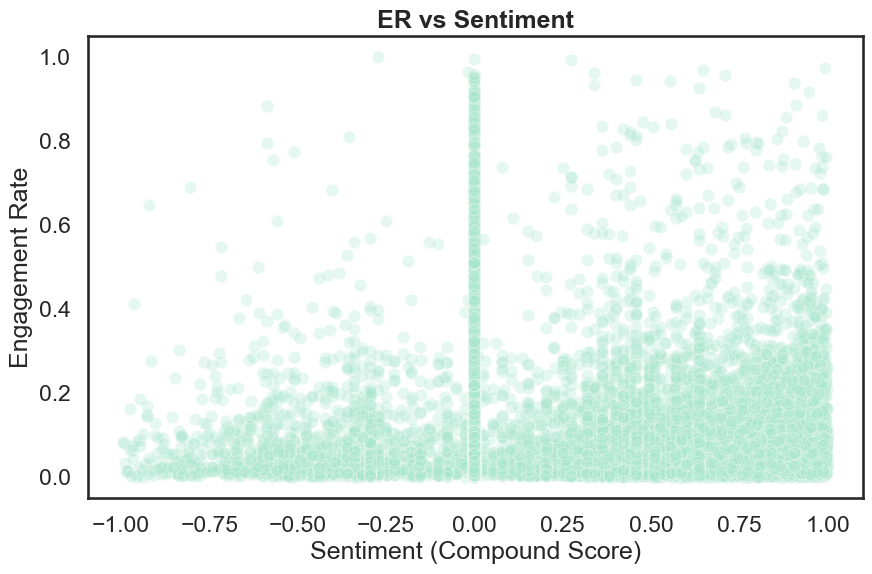

In [68]:
sns.scatterplot(data=df, x="sent_compound", y="ER", alpha=0.3, color="#A8E6CF")
plt.title("ER vs Sentiment")
plt.xlabel("Sentiment (Compound Score)")
plt.ylabel("Engagement Rate")
plt.show()

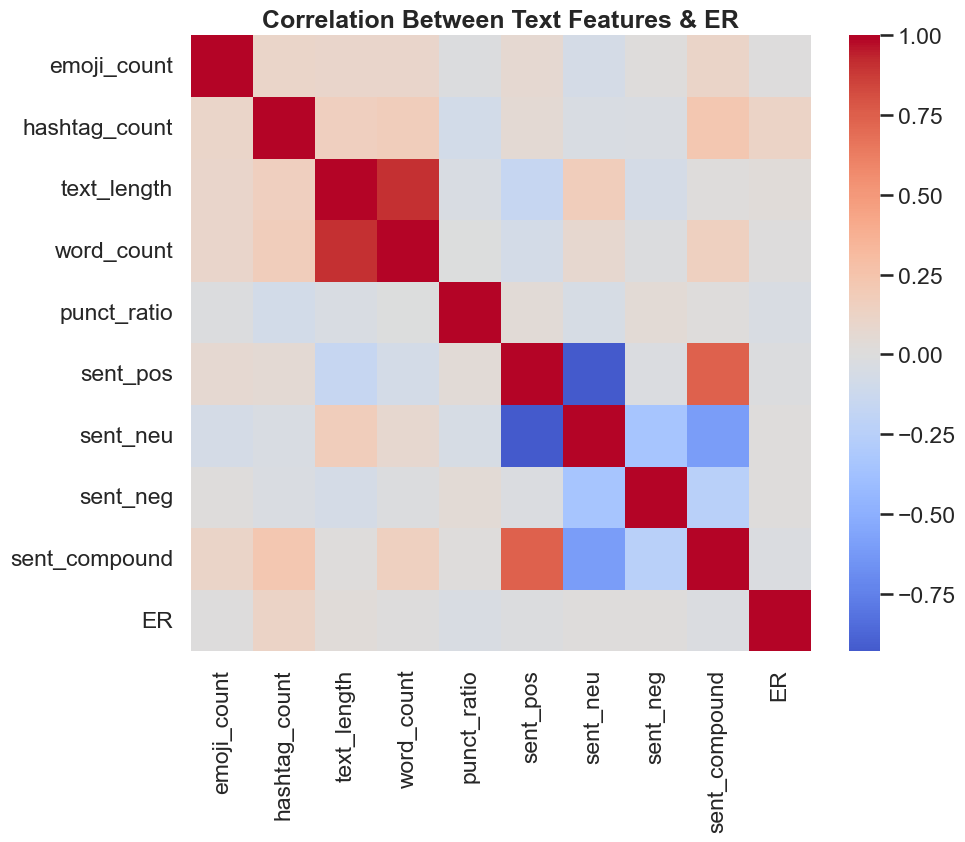

In [70]:
features = [
    "emoji_count","hashtag_count","text_length","word_count",
    "punct_ratio","sent_pos","sent_neu","sent_neg","sent_compound","ER"
]

plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Between Text Features & ER")
plt.show()

/var/folders/12/zfkj_y912yx094_b5wlc58040000gp/T/ipykernel_71475/499591600.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


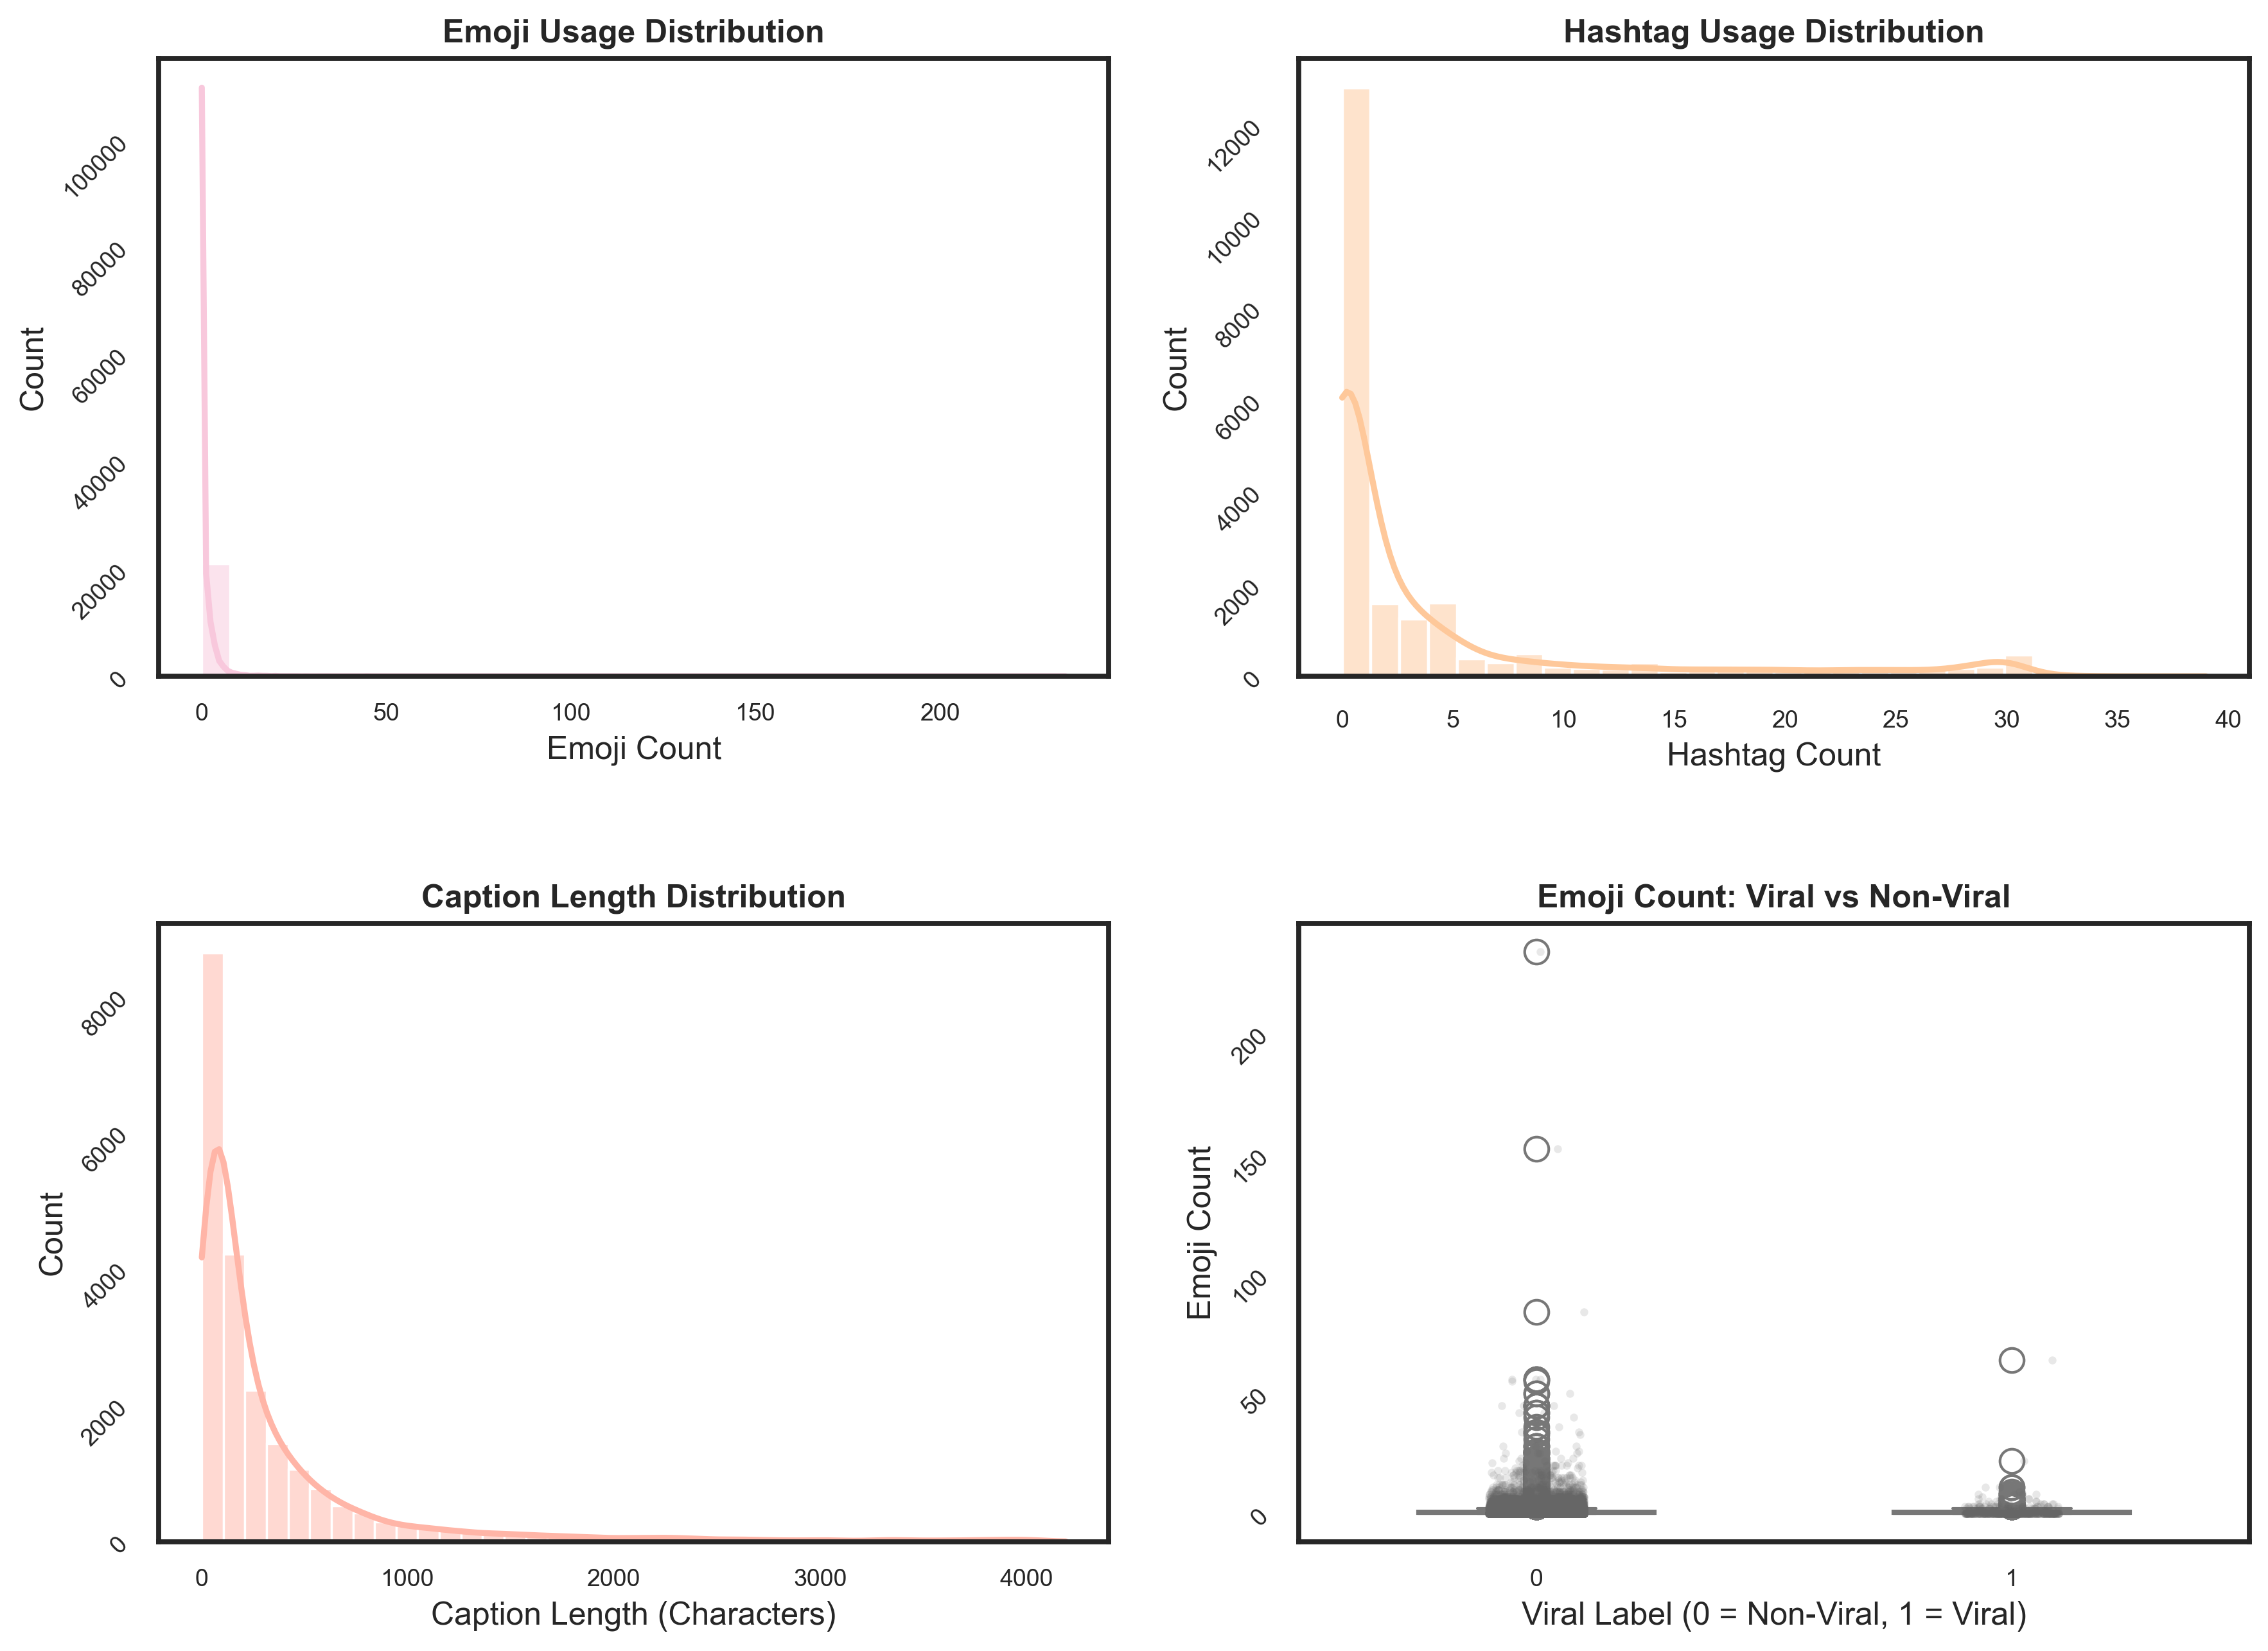

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===== Unified Aesthetic =====
FONT_SIZE = 11
TITLE_SIZE = 12
LABEL_SIZE = 12

# Soft pastel palette
P0 = "#F8C8DC"   # soft pink
P1 = "#FEC89A"   # peach
P2 = "#FFB5A7"   # rose
P3 = "#A3C4F3"   # lavender-blue
P4 = "#A8E6CF"   # mint

sns.set_style("white")
plt.rcParams['figure.facecolor'] = (0,0,0,0)
plt.rcParams['savefig.transparent'] = True

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=300)
plt.subplots_adjust(hspace=0.4, wspace=0.2)

# Make all y-axis labels rotated 45°
def rotate_y(ax):
    for label in ax.get_yticklabels():
        label.set_rotation(45)
        
def shrink_ticks(ax, size=9):
    ax.tick_params(axis='both', which='major', labelsize=size)

def tighten_ticks(ax, size=9, pad=1):
    ax.tick_params(
        axis='both',
        which='major',
        labelsize=size,
        pad=pad   # <-- controls distance to axis
    )

# ============================================================
# 1. Emoji Count Distribution
# ============================================================
ax = axes[0, 0]
sns.histplot(df["emoji_count"], bins=30, kde=True,
             color=P0, edgecolor="white", ax=ax)

ax.set_title("Emoji Usage Distribution", fontsize=TITLE_SIZE)
ax.set_xlabel("Emoji Count", fontsize=LABEL_SIZE)
ax.set_ylabel("Count", fontsize=LABEL_SIZE)
rotate_y(ax)
shrink_ticks(ax, size=9)
tighten_ticks(ax, size=9, pad=1)

# ax.text(0.55, 0.85, "Most posts contain\n0–2 emojis",
#         transform=ax.transAxes, fontsize=FONT_SIZE, color="#555")

# ============================================================
# 2. Hashtag Count Distribution
# ============================================================
ax = axes[0, 1]
sns.histplot(df["hashtag_count"], bins=30, kde=True,
             color=P1, edgecolor="white", ax=ax)

ax.set_title("Hashtag Usage Distribution", fontsize=TITLE_SIZE)
ax.set_xlabel("Hashtag Count", fontsize=LABEL_SIZE)
ax.set_ylabel("Count", fontsize=LABEL_SIZE)
rotate_y(ax)
shrink_ticks(ax, size=9)


# ax.text(0.50, 0.85, "Hashtags are used\nsparingly",
#         transform=ax.transAxes, fontsize=FONT_SIZE, color="#555")

# ============================================================
# 3. Caption Length Distribution
# ============================================================
ax = axes[1, 0]
sns.histplot(df["text_length"], bins=40, kde=True,
             color=P2, edgecolor="white", ax=ax)

ax.set_title("Caption Length Distribution", fontsize=TITLE_SIZE)
ax.set_xlabel("Caption Length (Characters)", fontsize=LABEL_SIZE)
ax.set_ylabel("Count", fontsize=LABEL_SIZE)
rotate_y(ax)
shrink_ticks(ax, size=9)
tighten_ticks(ax, size=9, pad=1)


# ax.text(0.50, 0.85, "Captions tend to be short",
#         transform=ax.transAxes, fontsize=FONT_SIZE, color="#555")

# ============================================================
# 4. Viral vs Non-Viral: Emoji Count
# ============================================================
ax = axes[1, 1]
sns.boxplot(
    data=df,
    x="viral_label",
    y="emoji_count",
    palette=[P3, P4],
    width=0.5,
    ax=ax
)
sns.stripplot(
    data=df,
    x="viral_label",
    y="emoji_count",
    color="#666",
    alpha=0.15,
    size=3,
    ax=ax
)

ax.set_title("Emoji Count: Viral vs Non-Viral", fontsize=TITLE_SIZE)
ax.set_xlabel("Viral Label (0 = Non-Viral, 1 = Viral)", fontsize=LABEL_SIZE)
ax.set_ylabel("Emoji Count", fontsize=LABEL_SIZE)
rotate_y(ax)
shrink_ticks(ax, size=9)
tighten_ticks(ax, size=9, pad=1)


# ax.text(0.25, 0.90,
#         "Viral posts exhibit\nslightly higher emoji use",
#         transform=ax.transAxes,
#         fontsize=FONT_SIZE, color="#555")

# Save Transparent
plt.savefig("text_feature_dashboard_transparent.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

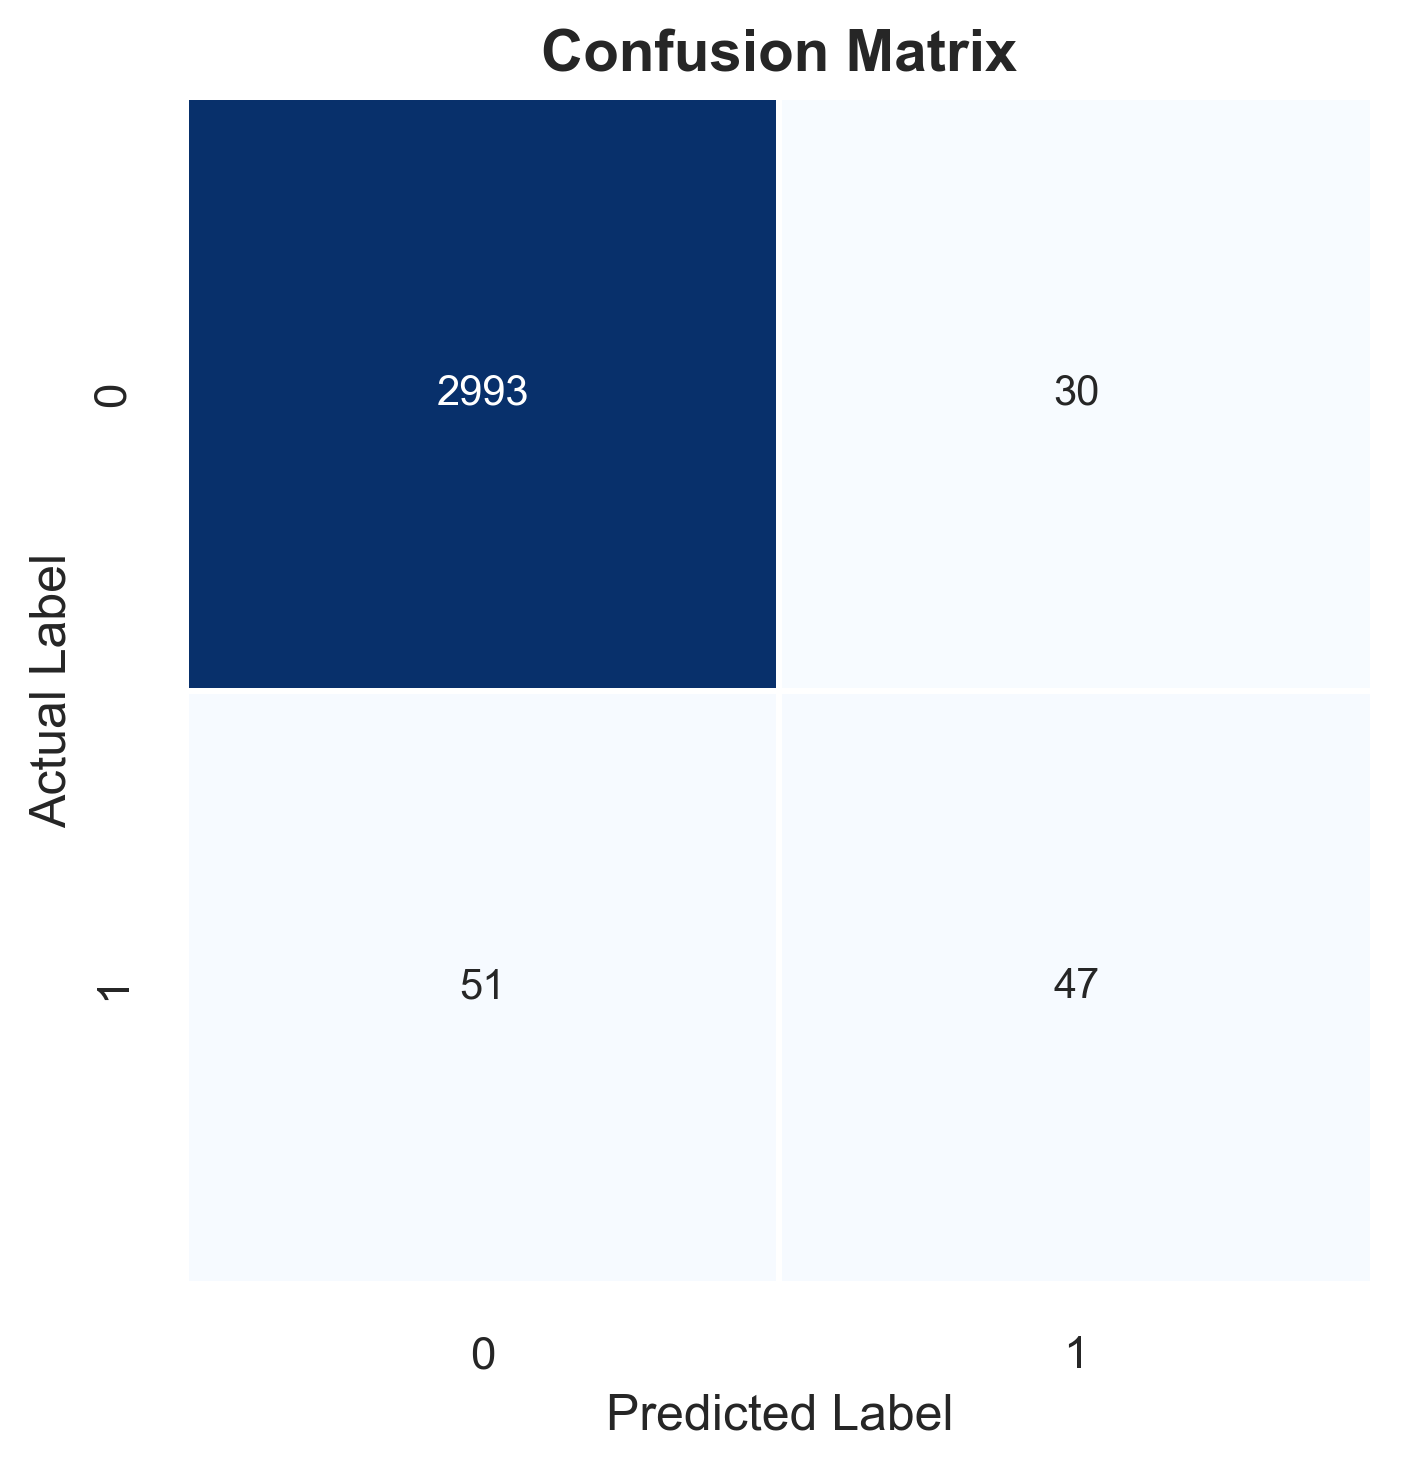

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Your confusion matrix
cm = np.array([
    [2993, 30],   # Actual 0: TN, FP
    [51,  47]    # Actual 1: FN, TP
])

plt.figure(figsize=(6,5), dpi=300)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=1,
    linecolor="white",
    square=True
)

# Make background transparent
plt.rcParams['figure.facecolor'] = (0,0,0,0)
plt.rcParams['savefig.transparent'] = True

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)

plt.xticks([0.5, 1.5], ["0", "1"], fontsize=11)
plt.yticks([0.5, 1.5], ["0", "1"], fontsize=11)

plt.tight_layout()
plt.savefig("confusion_matrix_standard.png", dpi=300, transparent=True)
plt.show()